### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [3]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [4]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [5]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/nik/.torch/models/inception_v3_google-1a9a5a14.pth
100.0%


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [7]:
import torch
from torch.autograd import Variable

dummy_x = Variable(torch.randn(5, 3, 299, 299))
model(dummy_x).shape

torch.Size([5, 1000])

### Predict class probabilities

/home/nik/Documents/ml/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


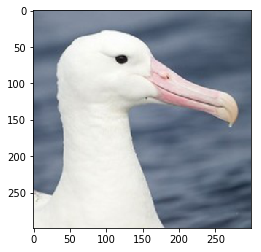

top-10 classes are: 
 [prob : class label]
0.9743 :	albatross
0.0031 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0004 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [8]:
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline

img = imresize(plt.imread('sample_images/albatross.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



### Having fun with pre-trained nets

In [9]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2019-02-24 11:11:59--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Распознаётся cdn.com.do (cdn.com.do)... 104.25.57.108, 104.25.58.108, 2606:4700:20::6819:396c, ...
Подключение к cdn.com.do (cdn.com.do)|104.25.57.108|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 301 Moved Permanently
Адрес: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [переход]
--2019-02-24 11:12:00--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Подключение к cdn.com.do (cdn.com.do)|104.25.57.108|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 51048 (50K) [image/jpeg]
Сохранение в каталог: ««img.jpg»».

img.jpg             100%[===================>]  49,85K  --.-KB/s    in 0,05s   

2019-02-24 11:12:01 (1,02 MB/s) - «img.jpg» сохранён [51048/51048]



/home/nik/Documents/ml/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


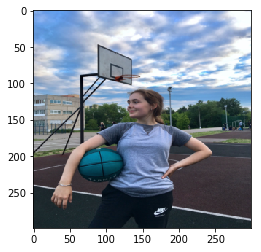

top-10 classes are: 
 [prob : class label]
0.1440 :	solar dish
0.0225 :	jersey
0.0190 :	balance beam
0.0185 :	bow
0.0122 :	electric fan
0.0116 :	racket
0.0108 :	suspension bridge
0.0092 :	bannister
0.0084 :	diaper


In [13]:
img = imresize(plt.imread('/home/nik/Downloads/dasha2.jpg'), (299,299)) / 255.
plt.imshow(img)
plt.show()

img = Variable(torch.FloatTensor(img.reshape([1, 299, 299, 3]).transpose([0,3,1,2])))

probs = torch.nn.functional.softmax(model(img), dim=-1)

probs = probs.data.numpy()

top_ix = probs.ravel().argsort()[-1:-10:-1]
print ('top-10 classes are: \n [prob : class label]')
for l in top_ix:
    print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))



# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [14]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

--2019-02-24 23:23:15--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Распознаётся www.dropbox.com (www.dropbox.com)... 162.125.70.1, 2620:100:6026:1::a27d:4601
Подключение к www.dropbox.com (www.dropbox.com)|162.125.70.1|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 301 Moved Permanently
Адрес: /s/dl/d61lupw909hc785/dogs_vs_cats.train.zip [переход]
--2019-02-24 23:23:16--  https://www.dropbox.com/s/dl/d61lupw909hc785/dogs_vs_cats.train.zip
Повторное использование соединения с www.dropbox.com:443.
HTTP-запрос отправлен. Ожидание ответа... 302 Found
Адрес: https://uc8c91474421ffea33d86043c0cf.dl.dropboxusercontent.com/cd/0/get/Ab8OVEksTNP0g4wzqJGOb_Rg6jq5KB8V4L6L0gjIZPwjUzCtCpyI9Qc-c1F2J6g90VGoQlsEE4Hyvv8pyzNXxvuP_Q1ICUyrY6Kic_Bc7zML6h2ut1rcoNP0tNBO1_HayGQ/file?dl=1# [переход]
--2019-02-24 23:23:17--  https://uc8c91474421ffea33d86043c0cf.dl.dropboxusercontent.com/cd/0/get/Ab8OVEksTNP0g4wzqJGOb_Rg6jq5KB8V4L6L0gjIZPwjUzCtCpyI9Qc-c1F2J6g

  inflating: train/cat.10202.jpg     
  inflating: train/cat.10203.jpg     
  inflating: train/cat.10204.jpg     
  inflating: train/cat.10205.jpg     
  inflating: train/cat.10206.jpg     
  inflating: train/cat.10207.jpg     
  inflating: train/cat.10208.jpg     
  inflating: train/cat.10209.jpg     
  inflating: train/cat.1021.jpg      
  inflating: train/cat.10210.jpg     
  inflating: train/cat.10211.jpg     
  inflating: train/cat.10212.jpg     
  inflating: train/cat.10213.jpg     
  inflating: train/cat.10214.jpg     
  inflating: train/cat.10215.jpg     
  inflating: train/cat.10216.jpg     
  inflating: train/cat.10217.jpg     
  inflating: train/cat.10218.jpg     
  inflating: train/cat.10219.jpg     
  inflating: train/cat.1022.jpg      
  inflating: train/cat.10220.jpg     
  inflating: train/cat.10221.jpg     
  inflating: train/cat.10222.jpg     
  inflating: train/cat.10223.jpg     
  inflating: train/cat.10224.jpg     
  inflating: train/cat.10225.jpg     
  inflating:

  inflating: train/cat.10454.jpg     
  inflating: train/cat.10455.jpg     
  inflating: train/cat.10456.jpg     
  inflating: train/cat.10457.jpg     
  inflating: train/cat.10458.jpg     
  inflating: train/cat.10459.jpg     
  inflating: train/cat.1046.jpg      
  inflating: train/cat.10460.jpg     
  inflating: train/cat.10461.jpg     
  inflating: train/cat.10462.jpg     
  inflating: train/cat.10463.jpg     
  inflating: train/cat.10464.jpg     
  inflating: train/cat.10465.jpg     
  inflating: train/cat.10466.jpg     
  inflating: train/cat.10467.jpg     
  inflating: train/cat.10468.jpg     
  inflating: train/cat.10469.jpg     
  inflating: train/cat.1047.jpg      
  inflating: train/cat.10470.jpg     
  inflating: train/cat.10471.jpg     
  inflating: train/cat.10472.jpg     
  inflating: train/cat.10473.jpg     
  inflating: train/cat.10474.jpg     
  inflating: train/cat.10475.jpg     
  inflating: train/cat.10476.jpg     
  inflating: train/cat.10477.jpg     
  inflating:

  inflating: train/cat.10652.jpg     
  inflating: train/cat.10653.jpg     
  inflating: train/cat.10654.jpg     
  inflating: train/cat.10655.jpg     
  inflating: train/cat.10656.jpg     
  inflating: train/cat.10657.jpg     
  inflating: train/cat.10658.jpg     
  inflating: train/cat.10659.jpg     
  inflating: train/cat.1066.jpg      
  inflating: train/cat.10660.jpg     
  inflating: train/cat.10661.jpg     
  inflating: train/cat.10662.jpg     
  inflating: train/cat.10663.jpg     
  inflating: train/cat.10664.jpg     
  inflating: train/cat.10665.jpg     
  inflating: train/cat.10666.jpg     
  inflating: train/cat.10667.jpg     
  inflating: train/cat.10668.jpg     
  inflating: train/cat.10669.jpg     
  inflating: train/cat.1067.jpg      
  inflating: train/cat.10670.jpg     
  inflating: train/cat.10671.jpg     
  inflating: train/cat.10672.jpg     
  inflating: train/cat.10673.jpg     
  inflating: train/cat.10674.jpg     
  inflating: train/cat.10675.jpg     
  inflating:

  inflating: train/cat.10850.jpg     
  inflating: train/cat.10851.jpg     
  inflating: train/cat.10852.jpg     
  inflating: train/cat.10853.jpg     
  inflating: train/cat.10854.jpg     
  inflating: train/cat.10855.jpg     
  inflating: train/cat.10856.jpg     
  inflating: train/cat.10857.jpg     
  inflating: train/cat.10858.jpg     
  inflating: train/cat.10859.jpg     
  inflating: train/cat.1086.jpg      
  inflating: train/cat.10860.jpg     
  inflating: train/cat.10861.jpg     
  inflating: train/cat.10862.jpg     
  inflating: train/cat.10863.jpg     
  inflating: train/cat.10864.jpg     
  inflating: train/cat.10865.jpg     
  inflating: train/cat.10866.jpg     
  inflating: train/cat.10867.jpg     
  inflating: train/cat.10868.jpg     
  inflating: train/cat.10869.jpg     
  inflating: train/cat.1087.jpg      
  inflating: train/cat.10870.jpg     
  inflating: train/cat.10871.jpg     
  inflating: train/cat.10872.jpg     
  inflating: train/cat.10873.jpg     
  inflating:

  inflating: train/cat.11125.jpg     
  inflating: train/cat.11126.jpg     
  inflating: train/cat.11127.jpg     
  inflating: train/cat.11128.jpg     
  inflating: train/cat.11129.jpg     
  inflating: train/cat.1113.jpg      
  inflating: train/cat.11130.jpg     
  inflating: train/cat.11131.jpg     
  inflating: train/cat.11132.jpg     
  inflating: train/cat.11133.jpg     
  inflating: train/cat.11134.jpg     
  inflating: train/cat.11135.jpg     
  inflating: train/cat.11136.jpg     
  inflating: train/cat.11137.jpg     
  inflating: train/cat.11138.jpg     
  inflating: train/cat.11139.jpg     
  inflating: train/cat.1114.jpg      
  inflating: train/cat.11140.jpg     
  inflating: train/cat.11141.jpg     
  inflating: train/cat.11142.jpg     
  inflating: train/cat.11143.jpg     
  inflating: train/cat.11144.jpg     
  inflating: train/cat.11145.jpg     
  inflating: train/cat.11146.jpg     
  inflating: train/cat.11147.jpg     
  inflating: train/cat.11148.jpg     
  inflating:

  inflating: train/cat.11333.jpg     
  inflating: train/cat.11334.jpg     
  inflating: train/cat.11335.jpg     
  inflating: train/cat.11336.jpg     
  inflating: train/cat.11337.jpg     
  inflating: train/cat.11338.jpg     
  inflating: train/cat.11339.jpg     
  inflating: train/cat.1134.jpg      
  inflating: train/cat.11340.jpg     
  inflating: train/cat.11341.jpg     
  inflating: train/cat.11342.jpg     
  inflating: train/cat.11343.jpg     
  inflating: train/cat.11344.jpg     
  inflating: train/cat.11345.jpg     
  inflating: train/cat.11346.jpg     
  inflating: train/cat.11347.jpg     
  inflating: train/cat.11348.jpg     
  inflating: train/cat.11349.jpg     
  inflating: train/cat.1135.jpg      
  inflating: train/cat.11350.jpg     
  inflating: train/cat.11351.jpg     
  inflating: train/cat.11352.jpg     
  inflating: train/cat.11353.jpg     
  inflating: train/cat.11354.jpg     
  inflating: train/cat.11355.jpg     
  inflating: train/cat.11356.jpg     
  inflating:

  inflating: train/cat.11549.jpg     
  inflating: train/cat.1155.jpg      
  inflating: train/cat.11550.jpg     
  inflating: train/cat.11551.jpg     
  inflating: train/cat.11552.jpg     
  inflating: train/cat.11553.jpg     
  inflating: train/cat.11554.jpg     
  inflating: train/cat.11555.jpg     
  inflating: train/cat.11556.jpg     
  inflating: train/cat.11557.jpg     
  inflating: train/cat.11558.jpg     
  inflating: train/cat.11559.jpg     
  inflating: train/cat.1156.jpg      
  inflating: train/cat.11560.jpg     
  inflating: train/cat.11561.jpg     
  inflating: train/cat.11562.jpg     
  inflating: train/cat.11563.jpg     
  inflating: train/cat.11564.jpg     
  inflating: train/cat.11565.jpg     
  inflating: train/cat.11566.jpg     
  inflating: train/cat.11567.jpg     
  inflating: train/cat.11568.jpg     
  inflating: train/cat.11569.jpg     
  inflating: train/cat.1157.jpg      
  inflating: train/cat.11570.jpg     
  inflating: train/cat.11571.jpg     
  inflating:

  inflating: train/cat.11807.jpg     
  inflating: train/cat.11808.jpg     
  inflating: train/cat.11809.jpg     
  inflating: train/cat.1181.jpg      
  inflating: train/cat.11810.jpg     
  inflating: train/cat.11811.jpg     
  inflating: train/cat.11812.jpg     
  inflating: train/cat.11813.jpg     
  inflating: train/cat.11814.jpg     
  inflating: train/cat.11815.jpg     
  inflating: train/cat.11816.jpg     
  inflating: train/cat.11817.jpg     
  inflating: train/cat.11818.jpg     
  inflating: train/cat.11819.jpg     
  inflating: train/cat.1182.jpg      
  inflating: train/cat.11820.jpg     
  inflating: train/cat.11821.jpg     
  inflating: train/cat.11822.jpg     
  inflating: train/cat.11823.jpg     
  inflating: train/cat.11824.jpg     
  inflating: train/cat.11825.jpg     
  inflating: train/cat.11826.jpg     
  inflating: train/cat.11827.jpg     
  inflating: train/cat.11828.jpg     
  inflating: train/cat.11829.jpg     
  inflating: train/cat.1183.jpg      
  inflating:

  inflating: train/cat.12028.jpg     
  inflating: train/cat.12029.jpg     
  inflating: train/cat.1203.jpg      
  inflating: train/cat.12030.jpg     
  inflating: train/cat.12031.jpg     
  inflating: train/cat.12032.jpg     
  inflating: train/cat.12033.jpg     
  inflating: train/cat.12034.jpg     
  inflating: train/cat.12035.jpg     
  inflating: train/cat.12036.jpg     
  inflating: train/cat.12037.jpg     
  inflating: train/cat.12038.jpg     
  inflating: train/cat.12039.jpg     
  inflating: train/cat.1204.jpg      
  inflating: train/cat.12040.jpg     
  inflating: train/cat.12041.jpg     
  inflating: train/cat.12042.jpg     
  inflating: train/cat.12043.jpg     
  inflating: train/cat.12044.jpg     
  inflating: train/cat.12045.jpg     
  inflating: train/cat.12046.jpg     
  inflating: train/cat.12047.jpg     
  inflating: train/cat.12048.jpg     
  inflating: train/cat.12049.jpg     
  inflating: train/cat.1205.jpg      
  inflating: train/cat.12050.jpg     
  inflating:

  inflating: train/cat.12275.jpg     
  inflating: train/cat.12276.jpg     
  inflating: train/cat.12277.jpg     
  inflating: train/cat.12278.jpg     
  inflating: train/cat.12279.jpg     
  inflating: train/cat.1228.jpg      
  inflating: train/cat.12280.jpg     
  inflating: train/cat.12281.jpg     
  inflating: train/cat.12282.jpg     
  inflating: train/cat.12283.jpg     
  inflating: train/cat.12284.jpg     
  inflating: train/cat.12285.jpg     
  inflating: train/cat.12286.jpg     
  inflating: train/cat.12287.jpg     
  inflating: train/cat.12288.jpg     
  inflating: train/cat.12289.jpg     
  inflating: train/cat.1229.jpg      
  inflating: train/cat.12290.jpg     
  inflating: train/cat.12291.jpg     
  inflating: train/cat.12292.jpg     
  inflating: train/cat.12293.jpg     
  inflating: train/cat.12294.jpg     
  inflating: train/cat.12295.jpg     
  inflating: train/cat.12296.jpg     
  inflating: train/cat.12297.jpg     
  inflating: train/cat.12298.jpg     
  inflating:

  inflating: train/cat.12483.jpg     
  inflating: train/cat.12484.jpg     
  inflating: train/cat.12485.jpg     
  inflating: train/cat.12486.jpg     
  inflating: train/cat.12487.jpg     
  inflating: train/cat.12488.jpg     
  inflating: train/cat.12489.jpg     
  inflating: train/cat.1249.jpg      
  inflating: train/cat.12490.jpg     
  inflating: train/cat.12491.jpg     
  inflating: train/cat.12492.jpg     
  inflating: train/cat.12493.jpg     
  inflating: train/cat.12494.jpg     
  inflating: train/cat.12495.jpg     
  inflating: train/cat.12496.jpg     
  inflating: train/cat.12497.jpg     
  inflating: train/cat.12498.jpg     
  inflating: train/cat.12499.jpg     
  inflating: train/cat.125.jpg       
  inflating: train/cat.1250.jpg      
  inflating: train/cat.1251.jpg      
  inflating: train/cat.1252.jpg      
  inflating: train/cat.1253.jpg      
  inflating: train/cat.1254.jpg      
  inflating: train/cat.1255.jpg      
  inflating: train/cat.1256.jpg      
  inflating:

  inflating: train/cat.1429.jpg      
  inflating: train/cat.143.jpg       
  inflating: train/cat.1430.jpg      
  inflating: train/cat.1431.jpg      
  inflating: train/cat.1432.jpg      
  inflating: train/cat.1433.jpg      
  inflating: train/cat.1434.jpg      
  inflating: train/cat.1435.jpg      
  inflating: train/cat.1436.jpg      
  inflating: train/cat.1437.jpg      
  inflating: train/cat.1438.jpg      
  inflating: train/cat.1439.jpg      
  inflating: train/cat.144.jpg       
  inflating: train/cat.1440.jpg      
  inflating: train/cat.1441.jpg      
  inflating: train/cat.1442.jpg      
  inflating: train/cat.1443.jpg      
  inflating: train/cat.1444.jpg      
  inflating: train/cat.1445.jpg      
  inflating: train/cat.1446.jpg      
  inflating: train/cat.1447.jpg      
  inflating: train/cat.1448.jpg      
  inflating: train/cat.1449.jpg      
  inflating: train/cat.145.jpg       
  inflating: train/cat.1450.jpg      
  inflating: train/cat.1451.jpg      
  inflating:

  inflating: train/cat.1667.jpg      
  inflating: train/cat.1668.jpg      
  inflating: train/cat.1669.jpg      
  inflating: train/cat.167.jpg       
  inflating: train/cat.1670.jpg      
  inflating: train/cat.1671.jpg      
  inflating: train/cat.1672.jpg      
  inflating: train/cat.1673.jpg      
  inflating: train/cat.1674.jpg      
  inflating: train/cat.1675.jpg      
  inflating: train/cat.1676.jpg      
  inflating: train/cat.1677.jpg      
  inflating: train/cat.1678.jpg      
  inflating: train/cat.1679.jpg      
  inflating: train/cat.168.jpg       
  inflating: train/cat.1680.jpg      
  inflating: train/cat.1681.jpg      
  inflating: train/cat.1682.jpg      
  inflating: train/cat.1683.jpg      
  inflating: train/cat.1684.jpg      
  inflating: train/cat.1685.jpg      
  inflating: train/cat.1686.jpg      
  inflating: train/cat.1687.jpg      
  inflating: train/cat.1688.jpg      
  inflating: train/cat.1689.jpg      
  inflating: train/cat.169.jpg       
  inflating:

  inflating: train/cat.187.jpg       
  inflating: train/cat.1870.jpg      
  inflating: train/cat.1871.jpg      
  inflating: train/cat.1872.jpg      
  inflating: train/cat.1873.jpg      
  inflating: train/cat.1874.jpg      
  inflating: train/cat.1875.jpg      
  inflating: train/cat.1876.jpg      
  inflating: train/cat.1877.jpg      
  inflating: train/cat.1878.jpg      
  inflating: train/cat.1879.jpg      
  inflating: train/cat.188.jpg       
  inflating: train/cat.1880.jpg      
  inflating: train/cat.1881.jpg      
  inflating: train/cat.1882.jpg      
  inflating: train/cat.1883.jpg      
  inflating: train/cat.1884.jpg      
  inflating: train/cat.1885.jpg      
  inflating: train/cat.1886.jpg      
  inflating: train/cat.1887.jpg      
  inflating: train/cat.1888.jpg      
  inflating: train/cat.1889.jpg      
  inflating: train/cat.189.jpg       
  inflating: train/cat.1890.jpg      
  inflating: train/cat.1891.jpg      
  inflating: train/cat.1892.jpg      
  inflating:

  inflating: train/cat.2122.jpg      
  inflating: train/cat.2123.jpg      
  inflating: train/cat.2124.jpg      
  inflating: train/cat.2125.jpg      
  inflating: train/cat.2126.jpg      
  inflating: train/cat.2127.jpg      
  inflating: train/cat.2128.jpg      
  inflating: train/cat.2129.jpg      
  inflating: train/cat.213.jpg       
  inflating: train/cat.2130.jpg      
  inflating: train/cat.2131.jpg      
  inflating: train/cat.2132.jpg      
  inflating: train/cat.2133.jpg      
  inflating: train/cat.2134.jpg      
  inflating: train/cat.2135.jpg      
  inflating: train/cat.2136.jpg      
  inflating: train/cat.2137.jpg      
  inflating: train/cat.2138.jpg      
  inflating: train/cat.2139.jpg      
  inflating: train/cat.214.jpg       
  inflating: train/cat.2140.jpg      
  inflating: train/cat.2141.jpg      
  inflating: train/cat.2142.jpg      
  inflating: train/cat.2143.jpg      
  inflating: train/cat.2144.jpg      
  inflating: train/cat.2145.jpg      
  inflating:

  inflating: train/cat.2327.jpg      
  inflating: train/cat.2328.jpg      
  inflating: train/cat.2329.jpg      
  inflating: train/cat.233.jpg       
  inflating: train/cat.2330.jpg      
  inflating: train/cat.2331.jpg      
  inflating: train/cat.2332.jpg      
  inflating: train/cat.2333.jpg      
  inflating: train/cat.2334.jpg      
  inflating: train/cat.2335.jpg      
  inflating: train/cat.2336.jpg      
  inflating: train/cat.2337.jpg      
  inflating: train/cat.2338.jpg      
  inflating: train/cat.2339.jpg      
  inflating: train/cat.234.jpg       
  inflating: train/cat.2340.jpg      
  inflating: train/cat.2341.jpg      
  inflating: train/cat.2342.jpg      
  inflating: train/cat.2343.jpg      
  inflating: train/cat.2344.jpg      
  inflating: train/cat.2345.jpg      
  inflating: train/cat.2346.jpg      
  inflating: train/cat.2347.jpg      
  inflating: train/cat.2348.jpg      
  inflating: train/cat.2349.jpg      
  inflating: train/cat.235.jpg       
  inflating:

  inflating: train/cat.2521.jpg      
  inflating: train/cat.2522.jpg      
  inflating: train/cat.2523.jpg      
  inflating: train/cat.2524.jpg      
  inflating: train/cat.2525.jpg      
  inflating: train/cat.2526.jpg      
  inflating: train/cat.2527.jpg      
  inflating: train/cat.2528.jpg      
  inflating: train/cat.2529.jpg      
  inflating: train/cat.253.jpg       
  inflating: train/cat.2530.jpg      
  inflating: train/cat.2531.jpg      
  inflating: train/cat.2532.jpg      
  inflating: train/cat.2533.jpg      
  inflating: train/cat.2534.jpg      
  inflating: train/cat.2535.jpg      
  inflating: train/cat.2536.jpg      
  inflating: train/cat.2537.jpg      
  inflating: train/cat.2538.jpg      
  inflating: train/cat.2539.jpg      
  inflating: train/cat.254.jpg       
  inflating: train/cat.2540.jpg      
  inflating: train/cat.2541.jpg      
  inflating: train/cat.2542.jpg      
  inflating: train/cat.2543.jpg      
  inflating: train/cat.2544.jpg      
  inflating:

  inflating: train/cat.2745.jpg      
  inflating: train/cat.2746.jpg      
  inflating: train/cat.2747.jpg      
  inflating: train/cat.2748.jpg      
  inflating: train/cat.2749.jpg      
  inflating: train/cat.275.jpg       
  inflating: train/cat.2750.jpg      
  inflating: train/cat.2751.jpg      
  inflating: train/cat.2752.jpg      
  inflating: train/cat.2753.jpg      
  inflating: train/cat.2754.jpg      
  inflating: train/cat.2755.jpg      
  inflating: train/cat.2756.jpg      
  inflating: train/cat.2757.jpg      
  inflating: train/cat.2758.jpg      
  inflating: train/cat.2759.jpg      
  inflating: train/cat.276.jpg       
  inflating: train/cat.2760.jpg      
  inflating: train/cat.2761.jpg      
  inflating: train/cat.2762.jpg      
  inflating: train/cat.2763.jpg      
  inflating: train/cat.2764.jpg      
  inflating: train/cat.2765.jpg      
  inflating: train/cat.2766.jpg      
  inflating: train/cat.2767.jpg      
  inflating: train/cat.2768.jpg      
  inflating:

  inflating: train/cat.2986.jpg      
  inflating: train/cat.2987.jpg      
  inflating: train/cat.2988.jpg      
  inflating: train/cat.2989.jpg      
  inflating: train/cat.299.jpg       
  inflating: train/cat.2990.jpg      
  inflating: train/cat.2991.jpg      
  inflating: train/cat.2992.jpg      
  inflating: train/cat.2993.jpg      
  inflating: train/cat.2994.jpg      
  inflating: train/cat.2995.jpg      
  inflating: train/cat.2996.jpg      
  inflating: train/cat.2997.jpg      
  inflating: train/cat.2998.jpg      
  inflating: train/cat.2999.jpg      
  inflating: train/cat.3.jpg         
  inflating: train/cat.30.jpg        
  inflating: train/cat.300.jpg       
  inflating: train/cat.3000.jpg      
  inflating: train/cat.3001.jpg      
  inflating: train/cat.3002.jpg      
  inflating: train/cat.3003.jpg      
  inflating: train/cat.3004.jpg      
  inflating: train/cat.3005.jpg      
  inflating: train/cat.3006.jpg      
  inflating: train/cat.3007.jpg      
  inflating:

  inflating: train/cat.3260.jpg      
  inflating: train/cat.3261.jpg      
  inflating: train/cat.3262.jpg      
  inflating: train/cat.3263.jpg      
  inflating: train/cat.3264.jpg      
  inflating: train/cat.3265.jpg      
  inflating: train/cat.3266.jpg      
  inflating: train/cat.3267.jpg      
  inflating: train/cat.3268.jpg      
  inflating: train/cat.3269.jpg      
  inflating: train/cat.327.jpg       
  inflating: train/cat.3270.jpg      
  inflating: train/cat.3271.jpg      
  inflating: train/cat.3272.jpg      
  inflating: train/cat.3273.jpg      
  inflating: train/cat.3274.jpg      
  inflating: train/cat.3275.jpg      
  inflating: train/cat.3276.jpg      
  inflating: train/cat.3277.jpg      
  inflating: train/cat.3278.jpg      
  inflating: train/cat.3279.jpg      
  inflating: train/cat.328.jpg       
  inflating: train/cat.3280.jpg      
  inflating: train/cat.3281.jpg      
  inflating: train/cat.3282.jpg      
  inflating: train/cat.3283.jpg      
  inflating:

  inflating: train/cat.352.jpg       
  inflating: train/cat.3520.jpg      
  inflating: train/cat.3521.jpg      
  inflating: train/cat.3522.jpg      
  inflating: train/cat.3523.jpg      
  inflating: train/cat.3524.jpg      
  inflating: train/cat.3525.jpg      
  inflating: train/cat.3526.jpg      
  inflating: train/cat.3527.jpg      
  inflating: train/cat.3528.jpg      
  inflating: train/cat.3529.jpg      
  inflating: train/cat.353.jpg       
  inflating: train/cat.3530.jpg      
  inflating: train/cat.3531.jpg      
  inflating: train/cat.3532.jpg      
  inflating: train/cat.3533.jpg      
  inflating: train/cat.3534.jpg      
  inflating: train/cat.3535.jpg      
  inflating: train/cat.3536.jpg      
  inflating: train/cat.3537.jpg      
  inflating: train/cat.3538.jpg      
  inflating: train/cat.3539.jpg      
  inflating: train/cat.354.jpg       
  inflating: train/cat.3540.jpg      
  inflating: train/cat.3541.jpg      
  inflating: train/cat.3542.jpg      
  inflating:

  inflating: train/cat.3795.jpg      
  inflating: train/cat.3796.jpg      
  inflating: train/cat.3797.jpg      
  inflating: train/cat.3798.jpg      
  inflating: train/cat.3799.jpg      
  inflating: train/cat.38.jpg        
  inflating: train/cat.380.jpg       
  inflating: train/cat.3800.jpg      
  inflating: train/cat.3801.jpg      
  inflating: train/cat.3802.jpg      
  inflating: train/cat.3803.jpg      
  inflating: train/cat.3804.jpg      
  inflating: train/cat.3805.jpg      
  inflating: train/cat.3806.jpg      
  inflating: train/cat.3807.jpg      
  inflating: train/cat.3808.jpg      
  inflating: train/cat.3809.jpg      
  inflating: train/cat.381.jpg       
  inflating: train/cat.3810.jpg      
  inflating: train/cat.3811.jpg      
  inflating: train/cat.3812.jpg      
  inflating: train/cat.3813.jpg      
  inflating: train/cat.3814.jpg      
  inflating: train/cat.3815.jpg      
  inflating: train/cat.3816.jpg      
  inflating: train/cat.3817.jpg      
  inflating:

  inflating: train/cat.4011.jpg      
  inflating: train/cat.4012.jpg      
  inflating: train/cat.4013.jpg      
  inflating: train/cat.4014.jpg      
  inflating: train/cat.4015.jpg      
  inflating: train/cat.4016.jpg      
  inflating: train/cat.4017.jpg      
  inflating: train/cat.4018.jpg      
  inflating: train/cat.4019.jpg      
  inflating: train/cat.402.jpg       
  inflating: train/cat.4020.jpg      
  inflating: train/cat.4021.jpg      
  inflating: train/cat.4022.jpg      
  inflating: train/cat.4023.jpg      
  inflating: train/cat.4024.jpg      
  inflating: train/cat.4025.jpg      
  inflating: train/cat.4026.jpg      
  inflating: train/cat.4027.jpg      
  inflating: train/cat.4028.jpg      
  inflating: train/cat.4029.jpg      
  inflating: train/cat.403.jpg       
  inflating: train/cat.4030.jpg      
  inflating: train/cat.4031.jpg      
  inflating: train/cat.4032.jpg      
  inflating: train/cat.4033.jpg      
  inflating: train/cat.4034.jpg      
  inflating:

  inflating: train/cat.429.jpg       
  inflating: train/cat.4290.jpg      
  inflating: train/cat.4291.jpg      
  inflating: train/cat.4292.jpg      
  inflating: train/cat.4293.jpg      
  inflating: train/cat.4294.jpg      
  inflating: train/cat.4295.jpg      
  inflating: train/cat.4296.jpg      
  inflating: train/cat.4297.jpg      
  inflating: train/cat.4298.jpg      
  inflating: train/cat.4299.jpg      
  inflating: train/cat.43.jpg        
  inflating: train/cat.430.jpg       
  inflating: train/cat.4300.jpg      
  inflating: train/cat.4301.jpg      
  inflating: train/cat.4302.jpg      
  inflating: train/cat.4303.jpg      
  inflating: train/cat.4304.jpg      
  inflating: train/cat.4305.jpg      
  inflating: train/cat.4306.jpg      
  inflating: train/cat.4307.jpg      
  inflating: train/cat.4308.jpg      
  inflating: train/cat.4309.jpg      
  inflating: train/cat.431.jpg       
  inflating: train/cat.4310.jpg      
  inflating: train/cat.4311.jpg      
  inflating:

  inflating: train/cat.4508.jpg      
  inflating: train/cat.4509.jpg      
  inflating: train/cat.451.jpg       
  inflating: train/cat.4510.jpg      
  inflating: train/cat.4511.jpg      
  inflating: train/cat.4512.jpg      
  inflating: train/cat.4513.jpg      
  inflating: train/cat.4514.jpg      
  inflating: train/cat.4515.jpg      
  inflating: train/cat.4516.jpg      
  inflating: train/cat.4517.jpg      
  inflating: train/cat.4518.jpg      
  inflating: train/cat.4519.jpg      
  inflating: train/cat.452.jpg       
  inflating: train/cat.4520.jpg      
  inflating: train/cat.4521.jpg      
  inflating: train/cat.4522.jpg      
  inflating: train/cat.4523.jpg      
  inflating: train/cat.4524.jpg      
  inflating: train/cat.4525.jpg      
  inflating: train/cat.4526.jpg      
  inflating: train/cat.4527.jpg      
  inflating: train/cat.4528.jpg      
  inflating: train/cat.4529.jpg      
  inflating: train/cat.453.jpg       
  inflating: train/cat.4530.jpg      
  inflating:

  inflating: train/cat.4736.jpg      
  inflating: train/cat.4737.jpg      
  inflating: train/cat.4738.jpg      
  inflating: train/cat.4739.jpg      
  inflating: train/cat.474.jpg       
  inflating: train/cat.4740.jpg      
  inflating: train/cat.4741.jpg      
  inflating: train/cat.4742.jpg      
  inflating: train/cat.4743.jpg      
  inflating: train/cat.4744.jpg      
  inflating: train/cat.4745.jpg      
  inflating: train/cat.4746.jpg      
  inflating: train/cat.4747.jpg      
  inflating: train/cat.4748.jpg      
  inflating: train/cat.4749.jpg      
  inflating: train/cat.475.jpg       
  inflating: train/cat.4750.jpg      
  inflating: train/cat.4751.jpg      
  inflating: train/cat.4752.jpg      
  inflating: train/cat.4753.jpg      
  inflating: train/cat.4754.jpg      
  inflating: train/cat.4755.jpg      
  inflating: train/cat.4756.jpg      
  inflating: train/cat.4757.jpg      
  inflating: train/cat.4758.jpg      
  inflating: train/cat.4759.jpg      
  inflating:

  inflating: train/cat.4935.jpg      
  inflating: train/cat.4936.jpg      
  inflating: train/cat.4937.jpg      
  inflating: train/cat.4938.jpg      
  inflating: train/cat.4939.jpg      
  inflating: train/cat.494.jpg       
  inflating: train/cat.4940.jpg      
  inflating: train/cat.4941.jpg      
  inflating: train/cat.4942.jpg      
  inflating: train/cat.4943.jpg      
  inflating: train/cat.4944.jpg      
  inflating: train/cat.4945.jpg      
  inflating: train/cat.4946.jpg      
  inflating: train/cat.4947.jpg      
  inflating: train/cat.4948.jpg      
  inflating: train/cat.4949.jpg      
  inflating: train/cat.495.jpg       
  inflating: train/cat.4950.jpg      
  inflating: train/cat.4951.jpg      
  inflating: train/cat.4952.jpg      
  inflating: train/cat.4953.jpg      
  inflating: train/cat.4954.jpg      
  inflating: train/cat.4955.jpg      
  inflating: train/cat.4956.jpg      
  inflating: train/cat.4957.jpg      
  inflating: train/cat.4958.jpg      
  inflating:

  inflating: train/cat.5135.jpg      
  inflating: train/cat.5136.jpg      
  inflating: train/cat.5137.jpg      
  inflating: train/cat.5138.jpg      
  inflating: train/cat.5139.jpg      
  inflating: train/cat.514.jpg       
  inflating: train/cat.5140.jpg      
  inflating: train/cat.5141.jpg      
  inflating: train/cat.5142.jpg      
  inflating: train/cat.5143.jpg      
  inflating: train/cat.5144.jpg      
  inflating: train/cat.5145.jpg      
  inflating: train/cat.5146.jpg      
  inflating: train/cat.5147.jpg      
  inflating: train/cat.5148.jpg      
  inflating: train/cat.5149.jpg      
  inflating: train/cat.515.jpg       
  inflating: train/cat.5150.jpg      
  inflating: train/cat.5151.jpg      
  inflating: train/cat.5152.jpg      
  inflating: train/cat.5153.jpg      
  inflating: train/cat.5154.jpg      
  inflating: train/cat.5155.jpg      
  inflating: train/cat.5156.jpg      
  inflating: train/cat.5157.jpg      
  inflating: train/cat.5158.jpg      
  inflating:

  inflating: train/cat.5351.jpg      
  inflating: train/cat.5352.jpg      
  inflating: train/cat.5353.jpg      
  inflating: train/cat.5354.jpg      
  inflating: train/cat.5355.jpg      
  inflating: train/cat.5356.jpg      
  inflating: train/cat.5357.jpg      
  inflating: train/cat.5358.jpg      
  inflating: train/cat.5359.jpg      
  inflating: train/cat.536.jpg       
  inflating: train/cat.5360.jpg      
  inflating: train/cat.5361.jpg      
  inflating: train/cat.5362.jpg      
  inflating: train/cat.5363.jpg      
  inflating: train/cat.5364.jpg      
  inflating: train/cat.5365.jpg      
  inflating: train/cat.5366.jpg      
  inflating: train/cat.5367.jpg      
  inflating: train/cat.5368.jpg      
  inflating: train/cat.5369.jpg      
  inflating: train/cat.537.jpg       
  inflating: train/cat.5370.jpg      
  inflating: train/cat.5371.jpg      
  inflating: train/cat.5372.jpg      
  inflating: train/cat.5373.jpg      
  inflating: train/cat.5374.jpg      
  inflating:

  inflating: train/cat.5553.jpg      
  inflating: train/cat.5554.jpg      
  inflating: train/cat.5555.jpg      
  inflating: train/cat.5556.jpg      
  inflating: train/cat.5557.jpg      
  inflating: train/cat.5558.jpg      
  inflating: train/cat.5559.jpg      
  inflating: train/cat.556.jpg       
  inflating: train/cat.5560.jpg      
  inflating: train/cat.5561.jpg      
  inflating: train/cat.5562.jpg      
  inflating: train/cat.5563.jpg      
  inflating: train/cat.5564.jpg      
  inflating: train/cat.5565.jpg      
  inflating: train/cat.5566.jpg      
  inflating: train/cat.5567.jpg      
  inflating: train/cat.5568.jpg      
  inflating: train/cat.5569.jpg      
  inflating: train/cat.557.jpg       
  inflating: train/cat.5570.jpg      
  inflating: train/cat.5571.jpg      
  inflating: train/cat.5572.jpg      
  inflating: train/cat.5573.jpg      
  inflating: train/cat.5574.jpg      
  inflating: train/cat.5575.jpg      
  inflating: train/cat.5576.jpg      
  inflating:

  inflating: train/cat.5776.jpg      
  inflating: train/cat.5777.jpg      
  inflating: train/cat.5778.jpg      
  inflating: train/cat.5779.jpg      
  inflating: train/cat.578.jpg       
  inflating: train/cat.5780.jpg      
  inflating: train/cat.5781.jpg      
  inflating: train/cat.5782.jpg      
  inflating: train/cat.5783.jpg      
  inflating: train/cat.5784.jpg      
  inflating: train/cat.5785.jpg      
  inflating: train/cat.5786.jpg      
  inflating: train/cat.5787.jpg      
  inflating: train/cat.5788.jpg      
  inflating: train/cat.5789.jpg      
  inflating: train/cat.579.jpg       
  inflating: train/cat.5790.jpg      
  inflating: train/cat.5791.jpg      
  inflating: train/cat.5792.jpg      
  inflating: train/cat.5793.jpg      
  inflating: train/cat.5794.jpg      
  inflating: train/cat.5795.jpg      
  inflating: train/cat.5796.jpg      
  inflating: train/cat.5797.jpg      
  inflating: train/cat.5798.jpg      
  inflating: train/cat.5799.jpg      
  inflating:

  inflating: train/cat.5988.jpg      
  inflating: train/cat.5989.jpg      
  inflating: train/cat.599.jpg       
  inflating: train/cat.5990.jpg      
  inflating: train/cat.5991.jpg      
  inflating: train/cat.5992.jpg      
  inflating: train/cat.5993.jpg      
  inflating: train/cat.5994.jpg      
  inflating: train/cat.5995.jpg      
  inflating: train/cat.5996.jpg      
  inflating: train/cat.5997.jpg      
  inflating: train/cat.5998.jpg      
  inflating: train/cat.5999.jpg      
  inflating: train/cat.6.jpg         
  inflating: train/cat.60.jpg        
  inflating: train/cat.600.jpg       
  inflating: train/cat.6000.jpg      
  inflating: train/cat.6001.jpg      
  inflating: train/cat.6002.jpg      
  inflating: train/cat.6003.jpg      
  inflating: train/cat.6004.jpg      
  inflating: train/cat.6005.jpg      
  inflating: train/cat.6006.jpg      
  inflating: train/cat.6007.jpg      
  inflating: train/cat.6008.jpg      
  inflating: train/cat.6009.jpg      
  inflating:

  inflating: train/cat.6194.jpg      
  inflating: train/cat.6195.jpg      
  inflating: train/cat.6196.jpg      
  inflating: train/cat.6197.jpg      
  inflating: train/cat.6198.jpg      
  inflating: train/cat.6199.jpg      
  inflating: train/cat.62.jpg        
  inflating: train/cat.620.jpg       
  inflating: train/cat.6200.jpg      
  inflating: train/cat.6201.jpg      
  inflating: train/cat.6202.jpg      
  inflating: train/cat.6203.jpg      
  inflating: train/cat.6204.jpg      
  inflating: train/cat.6205.jpg      
  inflating: train/cat.6206.jpg      
  inflating: train/cat.6207.jpg      
  inflating: train/cat.6208.jpg      
  inflating: train/cat.6209.jpg      
  inflating: train/cat.621.jpg       
  inflating: train/cat.6210.jpg      
  inflating: train/cat.6211.jpg      
  inflating: train/cat.6212.jpg      
  inflating: train/cat.6213.jpg      
  inflating: train/cat.6214.jpg      
  inflating: train/cat.6215.jpg      
  inflating: train/cat.6216.jpg      
  inflating:

  inflating: train/cat.6457.jpg      
  inflating: train/cat.6458.jpg      
  inflating: train/cat.6459.jpg      
  inflating: train/cat.646.jpg       
  inflating: train/cat.6460.jpg      
  inflating: train/cat.6461.jpg      
  inflating: train/cat.6462.jpg      
  inflating: train/cat.6463.jpg      
  inflating: train/cat.6464.jpg      
  inflating: train/cat.6465.jpg      
  inflating: train/cat.6466.jpg      
  inflating: train/cat.6467.jpg      
  inflating: train/cat.6468.jpg      
  inflating: train/cat.6469.jpg      
  inflating: train/cat.647.jpg       
  inflating: train/cat.6470.jpg      
  inflating: train/cat.6471.jpg      
  inflating: train/cat.6472.jpg      
  inflating: train/cat.6473.jpg      
  inflating: train/cat.6474.jpg      
  inflating: train/cat.6475.jpg      
  inflating: train/cat.6476.jpg      
  inflating: train/cat.6477.jpg      
  inflating: train/cat.6478.jpg      
  inflating: train/cat.6479.jpg      
  inflating: train/cat.648.jpg       
  inflating:

  inflating: train/cat.6728.jpg      
  inflating: train/cat.6729.jpg      
  inflating: train/cat.673.jpg       
  inflating: train/cat.6730.jpg      
  inflating: train/cat.6731.jpg      
  inflating: train/cat.6732.jpg      
  inflating: train/cat.6733.jpg      
  inflating: train/cat.6734.jpg      
  inflating: train/cat.6735.jpg      
  inflating: train/cat.6736.jpg      
  inflating: train/cat.6737.jpg      
  inflating: train/cat.6738.jpg      
  inflating: train/cat.6739.jpg      
  inflating: train/cat.674.jpg       
  inflating: train/cat.6740.jpg      
  inflating: train/cat.6741.jpg      
  inflating: train/cat.6742.jpg      
  inflating: train/cat.6743.jpg      
  inflating: train/cat.6744.jpg      
  inflating: train/cat.6745.jpg      
  inflating: train/cat.6746.jpg      
  inflating: train/cat.6747.jpg      
  inflating: train/cat.6748.jpg      
  inflating: train/cat.6749.jpg      
  inflating: train/cat.675.jpg       
  inflating: train/cat.6750.jpg      
  inflating:

  inflating: train/cat.695.jpg       
  inflating: train/cat.6950.jpg      
  inflating: train/cat.6951.jpg      
  inflating: train/cat.6952.jpg      
  inflating: train/cat.6953.jpg      
  inflating: train/cat.6954.jpg      
  inflating: train/cat.6955.jpg      
  inflating: train/cat.6956.jpg      
  inflating: train/cat.6957.jpg      
  inflating: train/cat.6958.jpg      
  inflating: train/cat.6959.jpg      
  inflating: train/cat.696.jpg       
  inflating: train/cat.6960.jpg      
  inflating: train/cat.6961.jpg      
  inflating: train/cat.6962.jpg      
  inflating: train/cat.6963.jpg      
  inflating: train/cat.6964.jpg      
  inflating: train/cat.6965.jpg      
  inflating: train/cat.6966.jpg      
  inflating: train/cat.6967.jpg      
  inflating: train/cat.6968.jpg      
  inflating: train/cat.6969.jpg      
  inflating: train/cat.697.jpg       
  inflating: train/cat.6970.jpg      
  inflating: train/cat.6971.jpg      
  inflating: train/cat.6972.jpg      
  inflating:

  inflating: train/cat.7157.jpg      
  inflating: train/cat.7158.jpg      
  inflating: train/cat.7159.jpg      
  inflating: train/cat.716.jpg       
  inflating: train/cat.7160.jpg      
  inflating: train/cat.7161.jpg      
  inflating: train/cat.7162.jpg      
  inflating: train/cat.7163.jpg      
  inflating: train/cat.7164.jpg      
  inflating: train/cat.7165.jpg      
  inflating: train/cat.7166.jpg      
  inflating: train/cat.7167.jpg      
  inflating: train/cat.7168.jpg      
  inflating: train/cat.7169.jpg      
  inflating: train/cat.717.jpg       
  inflating: train/cat.7170.jpg      
  inflating: train/cat.7171.jpg      
  inflating: train/cat.7172.jpg      
  inflating: train/cat.7173.jpg      
  inflating: train/cat.7174.jpg      
  inflating: train/cat.7175.jpg      
  inflating: train/cat.7176.jpg      
  inflating: train/cat.7177.jpg      
  inflating: train/cat.7178.jpg      
  inflating: train/cat.7179.jpg      
  inflating: train/cat.718.jpg       
  inflating:

  inflating: train/cat.7400.jpg      
  inflating: train/cat.7401.jpg      
  inflating: train/cat.7402.jpg      
  inflating: train/cat.7403.jpg      
  inflating: train/cat.7404.jpg      
  inflating: train/cat.7405.jpg      
  inflating: train/cat.7406.jpg      
  inflating: train/cat.7407.jpg      
  inflating: train/cat.7408.jpg      
  inflating: train/cat.7409.jpg      
  inflating: train/cat.741.jpg       
  inflating: train/cat.7410.jpg      
  inflating: train/cat.7411.jpg      
  inflating: train/cat.7412.jpg      
  inflating: train/cat.7413.jpg      
  inflating: train/cat.7414.jpg      
  inflating: train/cat.7415.jpg      
  inflating: train/cat.7416.jpg      
  inflating: train/cat.7417.jpg      
  inflating: train/cat.7418.jpg      
  inflating: train/cat.7419.jpg      
  inflating: train/cat.742.jpg       
  inflating: train/cat.7420.jpg      
  inflating: train/cat.7421.jpg      
  inflating: train/cat.7422.jpg      
  inflating: train/cat.7423.jpg      
  inflating:

  inflating: train/cat.7596.jpg      
  inflating: train/cat.7597.jpg      
  inflating: train/cat.7598.jpg      
  inflating: train/cat.7599.jpg      
  inflating: train/cat.76.jpg        
  inflating: train/cat.760.jpg       
  inflating: train/cat.7600.jpg      
  inflating: train/cat.7601.jpg      
  inflating: train/cat.7602.jpg      
  inflating: train/cat.7603.jpg      
  inflating: train/cat.7604.jpg      
  inflating: train/cat.7605.jpg      
  inflating: train/cat.7606.jpg      
  inflating: train/cat.7607.jpg      
  inflating: train/cat.7608.jpg      
  inflating: train/cat.7609.jpg      
  inflating: train/cat.761.jpg       
  inflating: train/cat.7610.jpg      
  inflating: train/cat.7611.jpg      
  inflating: train/cat.7612.jpg      
  inflating: train/cat.7613.jpg      
  inflating: train/cat.7614.jpg      
  inflating: train/cat.7615.jpg      
  inflating: train/cat.7616.jpg      
  inflating: train/cat.7617.jpg      
  inflating: train/cat.7618.jpg      
  inflating:

  inflating: train/cat.7793.jpg      
  inflating: train/cat.7794.jpg      
  inflating: train/cat.7795.jpg      
  inflating: train/cat.7796.jpg      
  inflating: train/cat.7797.jpg      
  inflating: train/cat.7798.jpg      
  inflating: train/cat.7799.jpg      
  inflating: train/cat.78.jpg        
  inflating: train/cat.780.jpg       
  inflating: train/cat.7800.jpg      
  inflating: train/cat.7801.jpg      
  inflating: train/cat.7802.jpg      
  inflating: train/cat.7803.jpg      
  inflating: train/cat.7804.jpg      
  inflating: train/cat.7805.jpg      
  inflating: train/cat.7806.jpg      
  inflating: train/cat.7807.jpg      
  inflating: train/cat.7808.jpg      
  inflating: train/cat.7809.jpg      
  inflating: train/cat.781.jpg       
  inflating: train/cat.7810.jpg      
  inflating: train/cat.7811.jpg      
  inflating: train/cat.7812.jpg      
  inflating: train/cat.7813.jpg      
  inflating: train/cat.7814.jpg      
  inflating: train/cat.7815.jpg      
  inflating:

  inflating: train/cat.8079.jpg      
  inflating: train/cat.808.jpg       
  inflating: train/cat.8080.jpg      
  inflating: train/cat.8081.jpg      
  inflating: train/cat.8082.jpg      
  inflating: train/cat.8083.jpg      
  inflating: train/cat.8084.jpg      
  inflating: train/cat.8085.jpg      
  inflating: train/cat.8086.jpg      
  inflating: train/cat.8087.jpg      
  inflating: train/cat.8088.jpg      
  inflating: train/cat.8089.jpg      
  inflating: train/cat.809.jpg       
  inflating: train/cat.8090.jpg      
  inflating: train/cat.8091.jpg      
  inflating: train/cat.8092.jpg      
  inflating: train/cat.8093.jpg      
  inflating: train/cat.8094.jpg      
  inflating: train/cat.8095.jpg      
  inflating: train/cat.8096.jpg      
  inflating: train/cat.8097.jpg      
  inflating: train/cat.8098.jpg      
  inflating: train/cat.8099.jpg      
  inflating: train/cat.81.jpg        
  inflating: train/cat.810.jpg       
  inflating: train/cat.8100.jpg      
  inflating:

  inflating: train/cat.8297.jpg      
  inflating: train/cat.8298.jpg      
  inflating: train/cat.8299.jpg      
  inflating: train/cat.83.jpg        
  inflating: train/cat.830.jpg       
  inflating: train/cat.8300.jpg      
  inflating: train/cat.8301.jpg      
  inflating: train/cat.8302.jpg      
  inflating: train/cat.8303.jpg      
  inflating: train/cat.8304.jpg      
  inflating: train/cat.8305.jpg      
  inflating: train/cat.8306.jpg      
  inflating: train/cat.8307.jpg      
  inflating: train/cat.8308.jpg      
  inflating: train/cat.8309.jpg      
  inflating: train/cat.831.jpg       
  inflating: train/cat.8310.jpg      
  inflating: train/cat.8311.jpg      
  inflating: train/cat.8312.jpg      
  inflating: train/cat.8313.jpg      
  inflating: train/cat.8314.jpg      
  inflating: train/cat.8315.jpg      
  inflating: train/cat.8316.jpg      
  inflating: train/cat.8317.jpg      
  inflating: train/cat.8318.jpg      
  inflating: train/cat.8319.jpg      
  inflating:

  inflating: train/cat.8552.jpg      
  inflating: train/cat.8553.jpg      
  inflating: train/cat.8554.jpg      
  inflating: train/cat.8555.jpg      
  inflating: train/cat.8556.jpg      
  inflating: train/cat.8557.jpg      
  inflating: train/cat.8558.jpg      
  inflating: train/cat.8559.jpg      
  inflating: train/cat.856.jpg       
  inflating: train/cat.8560.jpg      
  inflating: train/cat.8561.jpg      
  inflating: train/cat.8562.jpg      
  inflating: train/cat.8563.jpg      
  inflating: train/cat.8564.jpg      
  inflating: train/cat.8565.jpg      
  inflating: train/cat.8566.jpg      
  inflating: train/cat.8567.jpg      
  inflating: train/cat.8568.jpg      
  inflating: train/cat.8569.jpg      
  inflating: train/cat.857.jpg       
  inflating: train/cat.8570.jpg      
  inflating: train/cat.8571.jpg      
  inflating: train/cat.8572.jpg      
  inflating: train/cat.8573.jpg      
  inflating: train/cat.8574.jpg      
  inflating: train/cat.8575.jpg      
  inflating:

  inflating: train/cat.878.jpg       
  inflating: train/cat.8780.jpg      
  inflating: train/cat.8781.jpg      
  inflating: train/cat.8782.jpg      
  inflating: train/cat.8783.jpg      
  inflating: train/cat.8784.jpg      
  inflating: train/cat.8785.jpg      
  inflating: train/cat.8786.jpg      
  inflating: train/cat.8787.jpg      
  inflating: train/cat.8788.jpg      
  inflating: train/cat.8789.jpg      
  inflating: train/cat.879.jpg       
  inflating: train/cat.8790.jpg      
  inflating: train/cat.8791.jpg      
  inflating: train/cat.8792.jpg      
  inflating: train/cat.8793.jpg      
  inflating: train/cat.8794.jpg      
  inflating: train/cat.8795.jpg      
  inflating: train/cat.8796.jpg      
  inflating: train/cat.8797.jpg      
  inflating: train/cat.8798.jpg      
  inflating: train/cat.8799.jpg      
  inflating: train/cat.88.jpg        
  inflating: train/cat.880.jpg       
  inflating: train/cat.8800.jpg      
  inflating: train/cat.8801.jpg      
  inflating:

  inflating: train/cat.900.jpg       
  inflating: train/cat.9000.jpg      
  inflating: train/cat.9001.jpg      
  inflating: train/cat.9002.jpg      
  inflating: train/cat.9003.jpg      
  inflating: train/cat.9004.jpg      
  inflating: train/cat.9005.jpg      
  inflating: train/cat.9006.jpg      
  inflating: train/cat.9007.jpg      
  inflating: train/cat.9008.jpg      
  inflating: train/cat.9009.jpg      
  inflating: train/cat.901.jpg       
  inflating: train/cat.9010.jpg      
  inflating: train/cat.9011.jpg      
  inflating: train/cat.9012.jpg      
  inflating: train/cat.9013.jpg      
  inflating: train/cat.9014.jpg      
  inflating: train/cat.9015.jpg      
  inflating: train/cat.9016.jpg      
  inflating: train/cat.9017.jpg      
  inflating: train/cat.9018.jpg      
  inflating: train/cat.9019.jpg      
  inflating: train/cat.902.jpg       
  inflating: train/cat.9020.jpg      
  inflating: train/cat.9021.jpg      
  inflating: train/cat.9022.jpg      
  inflating:

  inflating: train/cat.9209.jpg      
  inflating: train/cat.921.jpg       
  inflating: train/cat.9210.jpg      
  inflating: train/cat.9211.jpg      
  inflating: train/cat.9212.jpg      
  inflating: train/cat.9213.jpg      
  inflating: train/cat.9214.jpg      
  inflating: train/cat.9215.jpg      
  inflating: train/cat.9216.jpg      
  inflating: train/cat.9217.jpg      
  inflating: train/cat.9218.jpg      
  inflating: train/cat.9219.jpg      
  inflating: train/cat.922.jpg       
  inflating: train/cat.9220.jpg      
  inflating: train/cat.9221.jpg      
  inflating: train/cat.9222.jpg      
  inflating: train/cat.9223.jpg      
  inflating: train/cat.9224.jpg      
  inflating: train/cat.9225.jpg      
  inflating: train/cat.9226.jpg      
  inflating: train/cat.9227.jpg      
  inflating: train/cat.9228.jpg      
  inflating: train/cat.9229.jpg      
  inflating: train/cat.923.jpg       
  inflating: train/cat.9230.jpg      
  inflating: train/cat.9231.jpg      
  inflating:

  inflating: train/cat.9459.jpg      
  inflating: train/cat.946.jpg       
  inflating: train/cat.9460.jpg      
  inflating: train/cat.9461.jpg      
  inflating: train/cat.9462.jpg      
  inflating: train/cat.9463.jpg      
  inflating: train/cat.9464.jpg      
  inflating: train/cat.9465.jpg      
  inflating: train/cat.9466.jpg      
  inflating: train/cat.9467.jpg      
  inflating: train/cat.9468.jpg      
  inflating: train/cat.9469.jpg      
  inflating: train/cat.947.jpg       
  inflating: train/cat.9470.jpg      
  inflating: train/cat.9471.jpg      
  inflating: train/cat.9472.jpg      
  inflating: train/cat.9473.jpg      
  inflating: train/cat.9474.jpg      
  inflating: train/cat.9475.jpg      
  inflating: train/cat.9476.jpg      
  inflating: train/cat.9477.jpg      
  inflating: train/cat.9478.jpg      
  inflating: train/cat.9479.jpg      
  inflating: train/cat.948.jpg       
  inflating: train/cat.9480.jpg      
  inflating: train/cat.9481.jpg      
  inflating:

  inflating: train/cat.9654.jpg      
  inflating: train/cat.9655.jpg      
  inflating: train/cat.9656.jpg      
  inflating: train/cat.9657.jpg      
  inflating: train/cat.9658.jpg      
  inflating: train/cat.9659.jpg      
  inflating: train/cat.966.jpg       
  inflating: train/cat.9660.jpg      
  inflating: train/cat.9661.jpg      
  inflating: train/cat.9662.jpg      
  inflating: train/cat.9663.jpg      
  inflating: train/cat.9664.jpg      
  inflating: train/cat.9665.jpg      
  inflating: train/cat.9666.jpg      
  inflating: train/cat.9667.jpg      
  inflating: train/cat.9668.jpg      
  inflating: train/cat.9669.jpg      
  inflating: train/cat.967.jpg       
  inflating: train/cat.9670.jpg      
  inflating: train/cat.9671.jpg      
  inflating: train/cat.9672.jpg      
  inflating: train/cat.9673.jpg      
  inflating: train/cat.9674.jpg      
  inflating: train/cat.9675.jpg      
  inflating: train/cat.9676.jpg      
  inflating: train/cat.9677.jpg      
  inflating:

  inflating: train/cat.9850.jpg      
  inflating: train/cat.9851.jpg      
  inflating: train/cat.9852.jpg      
  inflating: train/cat.9853.jpg      
  inflating: train/cat.9854.jpg      
  inflating: train/cat.9855.jpg      
  inflating: train/cat.9856.jpg      
  inflating: train/cat.9857.jpg      
  inflating: train/cat.9858.jpg      
  inflating: train/cat.9859.jpg      
  inflating: train/cat.986.jpg       
  inflating: train/cat.9860.jpg      
  inflating: train/cat.9861.jpg      
  inflating: train/cat.9862.jpg      
  inflating: train/cat.9863.jpg      
  inflating: train/cat.9864.jpg      
  inflating: train/cat.9865.jpg      
  inflating: train/cat.9866.jpg      
  inflating: train/cat.9867.jpg      
  inflating: train/cat.9868.jpg      
  inflating: train/cat.9869.jpg      
  inflating: train/cat.987.jpg       
  inflating: train/cat.9870.jpg      
  inflating: train/cat.9871.jpg      
  inflating: train/cat.9872.jpg      
  inflating: train/cat.9873.jpg      
  inflating:

  inflating: train/dog.10102.jpg     
  inflating: train/dog.10103.jpg     
  inflating: train/dog.10104.jpg     
  inflating: train/dog.10105.jpg     
  inflating: train/dog.10106.jpg     
  inflating: train/dog.10107.jpg     
  inflating: train/dog.10108.jpg     
  inflating: train/dog.10109.jpg     
  inflating: train/dog.1011.jpg      
  inflating: train/dog.10110.jpg     
  inflating: train/dog.10111.jpg     
  inflating: train/dog.10112.jpg     
  inflating: train/dog.10113.jpg     
  inflating: train/dog.10114.jpg     
  inflating: train/dog.10115.jpg     
  inflating: train/dog.10116.jpg     
  inflating: train/dog.10117.jpg     
  inflating: train/dog.10118.jpg     
  inflating: train/dog.10119.jpg     
  inflating: train/dog.1012.jpg      
  inflating: train/dog.10120.jpg     
  inflating: train/dog.10121.jpg     
  inflating: train/dog.10122.jpg     
  inflating: train/dog.10123.jpg     
  inflating: train/dog.10124.jpg     
  inflating: train/dog.10125.jpg     
  inflating:

  inflating: train/dog.10333.jpg     
  inflating: train/dog.10334.jpg     
  inflating: train/dog.10335.jpg     
  inflating: train/dog.10336.jpg     
  inflating: train/dog.10337.jpg     
  inflating: train/dog.10338.jpg     
  inflating: train/dog.10339.jpg     
  inflating: train/dog.1034.jpg      
  inflating: train/dog.10340.jpg     
  inflating: train/dog.10341.jpg     
  inflating: train/dog.10342.jpg     
  inflating: train/dog.10343.jpg     
  inflating: train/dog.10344.jpg     
  inflating: train/dog.10345.jpg     
  inflating: train/dog.10346.jpg     
  inflating: train/dog.10347.jpg     
  inflating: train/dog.10348.jpg     
  inflating: train/dog.10349.jpg     
  inflating: train/dog.1035.jpg      
  inflating: train/dog.10350.jpg     
  inflating: train/dog.10351.jpg     
  inflating: train/dog.10352.jpg     
  inflating: train/dog.10353.jpg     
  inflating: train/dog.10354.jpg     
  inflating: train/dog.10355.jpg     
  inflating: train/dog.10356.jpg     
  inflating:

  inflating: train/dog.1054.jpg      
  inflating: train/dog.10540.jpg     
  inflating: train/dog.10541.jpg     
  inflating: train/dog.10542.jpg     
  inflating: train/dog.10543.jpg     
  inflating: train/dog.10544.jpg     
  inflating: train/dog.10545.jpg     
  inflating: train/dog.10546.jpg     
  inflating: train/dog.10547.jpg     
  inflating: train/dog.10548.jpg     
  inflating: train/dog.10549.jpg     
  inflating: train/dog.1055.jpg      
  inflating: train/dog.10550.jpg     
  inflating: train/dog.10551.jpg     
  inflating: train/dog.10552.jpg     
  inflating: train/dog.10553.jpg     
  inflating: train/dog.10554.jpg     
  inflating: train/dog.10555.jpg     
  inflating: train/dog.10556.jpg     
  inflating: train/dog.10557.jpg     
  inflating: train/dog.10558.jpg     
  inflating: train/dog.10559.jpg     
  inflating: train/dog.1056.jpg      
  inflating: train/dog.10560.jpg     
  inflating: train/dog.10561.jpg     
  inflating: train/dog.10562.jpg     
  inflating:

  inflating: train/dog.10779.jpg     
  inflating: train/dog.1078.jpg      
  inflating: train/dog.10780.jpg     
  inflating: train/dog.10781.jpg     
  inflating: train/dog.10782.jpg     
  inflating: train/dog.10783.jpg     
  inflating: train/dog.10784.jpg     
  inflating: train/dog.10785.jpg     
  inflating: train/dog.10786.jpg     
  inflating: train/dog.10787.jpg     
  inflating: train/dog.10788.jpg     
  inflating: train/dog.10789.jpg     
  inflating: train/dog.1079.jpg      
  inflating: train/dog.10790.jpg     
  inflating: train/dog.10791.jpg     
  inflating: train/dog.10792.jpg     
  inflating: train/dog.10793.jpg     
  inflating: train/dog.10794.jpg     
  inflating: train/dog.10795.jpg     
  inflating: train/dog.10796.jpg     
  inflating: train/dog.10797.jpg     
  inflating: train/dog.10798.jpg     
  inflating: train/dog.10799.jpg     
  inflating: train/dog.108.jpg       
  inflating: train/dog.1080.jpg      
  inflating: train/dog.10800.jpg     
  inflating:

  inflating: train/dog.10978.jpg     
  inflating: train/dog.10979.jpg     
  inflating: train/dog.1098.jpg      
  inflating: train/dog.10980.jpg     
  inflating: train/dog.10981.jpg     
  inflating: train/dog.10982.jpg     
  inflating: train/dog.10983.jpg     
  inflating: train/dog.10984.jpg     
  inflating: train/dog.10985.jpg     
  inflating: train/dog.10986.jpg     
  inflating: train/dog.10987.jpg     
  inflating: train/dog.10988.jpg     
  inflating: train/dog.10989.jpg     
  inflating: train/dog.1099.jpg      
  inflating: train/dog.10990.jpg     
  inflating: train/dog.10991.jpg     
  inflating: train/dog.10992.jpg     
  inflating: train/dog.10993.jpg     
  inflating: train/dog.10994.jpg     
  inflating: train/dog.10995.jpg     
  inflating: train/dog.10996.jpg     
  inflating: train/dog.10997.jpg     
  inflating: train/dog.10998.jpg     
  inflating: train/dog.10999.jpg     
  inflating: train/dog.11.jpg        
  inflating: train/dog.110.jpg       
  inflating:

  inflating: train/dog.11172.jpg     
  inflating: train/dog.11173.jpg     
  inflating: train/dog.11174.jpg     
  inflating: train/dog.11175.jpg     
  inflating: train/dog.11176.jpg     
  inflating: train/dog.11177.jpg     
  inflating: train/dog.11178.jpg     
  inflating: train/dog.11179.jpg     
  inflating: train/dog.1118.jpg      
  inflating: train/dog.11180.jpg     
  inflating: train/dog.11181.jpg     
  inflating: train/dog.11182.jpg     
  inflating: train/dog.11183.jpg     
  inflating: train/dog.11184.jpg     
  inflating: train/dog.11185.jpg     
  inflating: train/dog.11186.jpg     
  inflating: train/dog.11187.jpg     
  inflating: train/dog.11188.jpg     
  inflating: train/dog.11189.jpg     
  inflating: train/dog.1119.jpg      
  inflating: train/dog.11190.jpg     
  inflating: train/dog.11191.jpg     
  inflating: train/dog.11192.jpg     
  inflating: train/dog.11193.jpg     
  inflating: train/dog.11194.jpg     
  inflating: train/dog.11195.jpg     
  inflating:

  inflating: train/dog.11441.jpg     
  inflating: train/dog.11442.jpg     
  inflating: train/dog.11443.jpg     
  inflating: train/dog.11444.jpg     
  inflating: train/dog.11445.jpg     
  inflating: train/dog.11446.jpg     
  inflating: train/dog.11447.jpg     
  inflating: train/dog.11448.jpg     
  inflating: train/dog.11449.jpg     
  inflating: train/dog.1145.jpg      
  inflating: train/dog.11450.jpg     
  inflating: train/dog.11451.jpg     
  inflating: train/dog.11452.jpg     
  inflating: train/dog.11453.jpg     
  inflating: train/dog.11454.jpg     
  inflating: train/dog.11455.jpg     
  inflating: train/dog.11456.jpg     
  inflating: train/dog.11457.jpg     
  inflating: train/dog.11458.jpg     
  inflating: train/dog.11459.jpg     
  inflating: train/dog.1146.jpg      
  inflating: train/dog.11460.jpg     
  inflating: train/dog.11461.jpg     
  inflating: train/dog.11462.jpg     
  inflating: train/dog.11463.jpg     
  inflating: train/dog.11464.jpg     
  inflating:

  inflating: train/dog.11637.jpg     
  inflating: train/dog.11638.jpg     
  inflating: train/dog.11639.jpg     
  inflating: train/dog.1164.jpg      
  inflating: train/dog.11640.jpg     
  inflating: train/dog.11641.jpg     
  inflating: train/dog.11642.jpg     
  inflating: train/dog.11643.jpg     
  inflating: train/dog.11644.jpg     
  inflating: train/dog.11645.jpg     
  inflating: train/dog.11646.jpg     
  inflating: train/dog.11647.jpg     
  inflating: train/dog.11648.jpg     
  inflating: train/dog.11649.jpg     
  inflating: train/dog.1165.jpg      
  inflating: train/dog.11650.jpg     
  inflating: train/dog.11651.jpg     
  inflating: train/dog.11652.jpg     
  inflating: train/dog.11653.jpg     
  inflating: train/dog.11654.jpg     
  inflating: train/dog.11655.jpg     
  inflating: train/dog.11656.jpg     
  inflating: train/dog.11657.jpg     
  inflating: train/dog.11658.jpg     
  inflating: train/dog.11659.jpg     
  inflating: train/dog.1166.jpg      
  inflating:

  inflating: train/dog.11834.jpg     
  inflating: train/dog.11835.jpg     
  inflating: train/dog.11836.jpg     
  inflating: train/dog.11837.jpg     
  inflating: train/dog.11838.jpg     
  inflating: train/dog.11839.jpg     
  inflating: train/dog.1184.jpg      
  inflating: train/dog.11840.jpg     
  inflating: train/dog.11841.jpg     
  inflating: train/dog.11842.jpg     
  inflating: train/dog.11843.jpg     
  inflating: train/dog.11844.jpg     
  inflating: train/dog.11845.jpg     
  inflating: train/dog.11846.jpg     
  inflating: train/dog.11847.jpg     
  inflating: train/dog.11848.jpg     
  inflating: train/dog.11849.jpg     
  inflating: train/dog.1185.jpg      
  inflating: train/dog.11850.jpg     
  inflating: train/dog.11851.jpg     
  inflating: train/dog.11852.jpg     
  inflating: train/dog.11853.jpg     
  inflating: train/dog.11854.jpg     
  inflating: train/dog.11855.jpg     
  inflating: train/dog.11856.jpg     
  inflating: train/dog.11857.jpg     
  inflating:

  inflating: train/dog.12038.jpg     
  inflating: train/dog.12039.jpg     
  inflating: train/dog.1204.jpg      
  inflating: train/dog.12040.jpg     
  inflating: train/dog.12041.jpg     
  inflating: train/dog.12042.jpg     
  inflating: train/dog.12043.jpg     
  inflating: train/dog.12044.jpg     
  inflating: train/dog.12045.jpg     
  inflating: train/dog.12046.jpg     
  inflating: train/dog.12047.jpg     
  inflating: train/dog.12048.jpg     
  inflating: train/dog.12049.jpg     
  inflating: train/dog.1205.jpg      
  inflating: train/dog.12050.jpg     
  inflating: train/dog.12051.jpg     
  inflating: train/dog.12052.jpg     
  inflating: train/dog.12053.jpg     
  inflating: train/dog.12054.jpg     
  inflating: train/dog.12055.jpg     
  inflating: train/dog.12056.jpg     
  inflating: train/dog.12057.jpg     
  inflating: train/dog.12058.jpg     
  inflating: train/dog.12059.jpg     
  inflating: train/dog.1206.jpg      
  inflating: train/dog.12060.jpg     
  inflating:

  inflating: train/dog.12241.jpg     
  inflating: train/dog.12242.jpg     
  inflating: train/dog.12243.jpg     
  inflating: train/dog.12244.jpg     
  inflating: train/dog.12245.jpg     
  inflating: train/dog.12246.jpg     
  inflating: train/dog.12247.jpg     
  inflating: train/dog.12248.jpg     
  inflating: train/dog.12249.jpg     
  inflating: train/dog.1225.jpg      
  inflating: train/dog.12250.jpg     
  inflating: train/dog.12251.jpg     
  inflating: train/dog.12252.jpg     
  inflating: train/dog.12253.jpg     
  inflating: train/dog.12254.jpg     
  inflating: train/dog.12255.jpg     
  inflating: train/dog.12256.jpg     
  inflating: train/dog.12257.jpg     
  inflating: train/dog.12258.jpg     
  inflating: train/dog.12259.jpg     
  inflating: train/dog.1226.jpg      
  inflating: train/dog.12260.jpg     
  inflating: train/dog.12261.jpg     
  inflating: train/dog.12262.jpg     
  inflating: train/dog.12263.jpg     
  inflating: train/dog.12264.jpg     
  inflating:

  inflating: train/dog.12441.jpg     
  inflating: train/dog.12442.jpg     
  inflating: train/dog.12443.jpg     
  inflating: train/dog.12444.jpg     
  inflating: train/dog.12445.jpg     
  inflating: train/dog.12446.jpg     
  inflating: train/dog.12447.jpg     
  inflating: train/dog.12448.jpg     
  inflating: train/dog.12449.jpg     
  inflating: train/dog.1245.jpg      
  inflating: train/dog.12450.jpg     
  inflating: train/dog.12451.jpg     
  inflating: train/dog.12452.jpg     
  inflating: train/dog.12453.jpg     
  inflating: train/dog.12454.jpg     
  inflating: train/dog.12455.jpg     
  inflating: train/dog.12456.jpg     
  inflating: train/dog.12457.jpg     
  inflating: train/dog.12458.jpg     
  inflating: train/dog.12459.jpg     
  inflating: train/dog.1246.jpg      
  inflating: train/dog.12460.jpg     
  inflating: train/dog.12461.jpg     
  inflating: train/dog.12462.jpg     
  inflating: train/dog.12463.jpg     
  inflating: train/dog.12464.jpg     
  inflating:

  inflating: train/dog.1456.jpg      
  inflating: train/dog.1457.jpg      
  inflating: train/dog.1458.jpg      
  inflating: train/dog.1459.jpg      
  inflating: train/dog.146.jpg       
  inflating: train/dog.1460.jpg      
  inflating: train/dog.1461.jpg      
  inflating: train/dog.1462.jpg      
  inflating: train/dog.1463.jpg      
  inflating: train/dog.1464.jpg      
  inflating: train/dog.1465.jpg      
  inflating: train/dog.1466.jpg      
  inflating: train/dog.1467.jpg      
  inflating: train/dog.1468.jpg      
  inflating: train/dog.1469.jpg      
  inflating: train/dog.147.jpg       
  inflating: train/dog.1470.jpg      
  inflating: train/dog.1471.jpg      
  inflating: train/dog.1472.jpg      
  inflating: train/dog.1473.jpg      
  inflating: train/dog.1474.jpg      
  inflating: train/dog.1475.jpg      
  inflating: train/dog.1476.jpg      
  inflating: train/dog.1477.jpg      
  inflating: train/dog.1478.jpg      
  inflating: train/dog.1479.jpg      
  inflating:

  inflating: train/dog.1666.jpg      
  inflating: train/dog.1667.jpg      
  inflating: train/dog.1668.jpg      
  inflating: train/dog.1669.jpg      
  inflating: train/dog.167.jpg       
  inflating: train/dog.1670.jpg      
  inflating: train/dog.1671.jpg      
  inflating: train/dog.1672.jpg      
  inflating: train/dog.1673.jpg      
  inflating: train/dog.1674.jpg      
  inflating: train/dog.1675.jpg      
  inflating: train/dog.1676.jpg      
  inflating: train/dog.1677.jpg      
  inflating: train/dog.1678.jpg      
  inflating: train/dog.1679.jpg      
  inflating: train/dog.168.jpg       
  inflating: train/dog.1680.jpg      
  inflating: train/dog.1681.jpg      
  inflating: train/dog.1682.jpg      
  inflating: train/dog.1683.jpg      
  inflating: train/dog.1684.jpg      
  inflating: train/dog.1685.jpg      
  inflating: train/dog.1686.jpg      
  inflating: train/dog.1687.jpg      
  inflating: train/dog.1688.jpg      
  inflating: train/dog.1689.jpg      
  inflating:

  inflating: train/dog.1879.jpg      
  inflating: train/dog.188.jpg       
  inflating: train/dog.1880.jpg      
  inflating: train/dog.1881.jpg      
  inflating: train/dog.1882.jpg      
  inflating: train/dog.1883.jpg      
  inflating: train/dog.1884.jpg      
  inflating: train/dog.1885.jpg      
  inflating: train/dog.1886.jpg      
  inflating: train/dog.1887.jpg      
  inflating: train/dog.1888.jpg      
  inflating: train/dog.1889.jpg      
  inflating: train/dog.189.jpg       
  inflating: train/dog.1890.jpg      
  inflating: train/dog.1891.jpg      
  inflating: train/dog.1892.jpg      
  inflating: train/dog.1893.jpg      
  inflating: train/dog.1894.jpg      
  inflating: train/dog.1895.jpg      
  inflating: train/dog.1896.jpg      
  inflating: train/dog.1897.jpg      
  inflating: train/dog.1898.jpg      
  inflating: train/dog.1899.jpg      
  inflating: train/dog.19.jpg        
  inflating: train/dog.190.jpg       
  inflating: train/dog.1900.jpg      
  inflating:

  inflating: train/dog.2079.jpg      
  inflating: train/dog.208.jpg       
  inflating: train/dog.2080.jpg      
  inflating: train/dog.2081.jpg      
  inflating: train/dog.2082.jpg      
  inflating: train/dog.2083.jpg      
  inflating: train/dog.2084.jpg      
  inflating: train/dog.2085.jpg      
  inflating: train/dog.2086.jpg      
  inflating: train/dog.2087.jpg      
  inflating: train/dog.2088.jpg      
  inflating: train/dog.2089.jpg      
  inflating: train/dog.209.jpg       
  inflating: train/dog.2090.jpg      
  inflating: train/dog.2091.jpg      
  inflating: train/dog.2092.jpg      
  inflating: train/dog.2093.jpg      
  inflating: train/dog.2094.jpg      
  inflating: train/dog.2095.jpg      
  inflating: train/dog.2096.jpg      
  inflating: train/dog.2097.jpg      
  inflating: train/dog.2098.jpg      
  inflating: train/dog.2099.jpg      
  inflating: train/dog.21.jpg        
  inflating: train/dog.210.jpg       
  inflating: train/dog.2100.jpg      
  inflating:

  inflating: train/dog.2273.jpg      
  inflating: train/dog.2274.jpg      
  inflating: train/dog.2275.jpg      
  inflating: train/dog.2276.jpg      
  inflating: train/dog.2277.jpg      
  inflating: train/dog.2278.jpg      
  inflating: train/dog.2279.jpg      
  inflating: train/dog.228.jpg       
  inflating: train/dog.2280.jpg      
  inflating: train/dog.2281.jpg      
  inflating: train/dog.2282.jpg      
  inflating: train/dog.2283.jpg      
  inflating: train/dog.2284.jpg      
  inflating: train/dog.2285.jpg      
  inflating: train/dog.2286.jpg      
  inflating: train/dog.2287.jpg      
  inflating: train/dog.2288.jpg      
  inflating: train/dog.2289.jpg      
  inflating: train/dog.229.jpg       
  inflating: train/dog.2290.jpg      
  inflating: train/dog.2291.jpg      
  inflating: train/dog.2292.jpg      
  inflating: train/dog.2293.jpg      
  inflating: train/dog.2294.jpg      
  inflating: train/dog.2295.jpg      
  inflating: train/dog.2296.jpg      
  inflating:

  inflating: train/dog.2541.jpg      
  inflating: train/dog.2542.jpg      
  inflating: train/dog.2543.jpg      
  inflating: train/dog.2544.jpg      
  inflating: train/dog.2545.jpg      
  inflating: train/dog.2546.jpg      
  inflating: train/dog.2547.jpg      
  inflating: train/dog.2548.jpg      
  inflating: train/dog.2549.jpg      
  inflating: train/dog.255.jpg       
  inflating: train/dog.2550.jpg      
  inflating: train/dog.2551.jpg      
  inflating: train/dog.2552.jpg      
  inflating: train/dog.2553.jpg      
  inflating: train/dog.2554.jpg      
  inflating: train/dog.2555.jpg      
  inflating: train/dog.2556.jpg      
  inflating: train/dog.2557.jpg      
  inflating: train/dog.2558.jpg      
  inflating: train/dog.2559.jpg      
  inflating: train/dog.256.jpg       
  inflating: train/dog.2560.jpg      
  inflating: train/dog.2561.jpg      
  inflating: train/dog.2562.jpg      
  inflating: train/dog.2563.jpg      
  inflating: train/dog.2564.jpg      
  inflating:

  inflating: train/dog.2761.jpg      
  inflating: train/dog.2762.jpg      
  inflating: train/dog.2763.jpg      
  inflating: train/dog.2764.jpg      
  inflating: train/dog.2765.jpg      
  inflating: train/dog.2766.jpg      
  inflating: train/dog.2767.jpg      
  inflating: train/dog.2768.jpg      
  inflating: train/dog.2769.jpg      
  inflating: train/dog.277.jpg       
  inflating: train/dog.2770.jpg      
  inflating: train/dog.2771.jpg      
  inflating: train/dog.2772.jpg      
  inflating: train/dog.2773.jpg      
  inflating: train/dog.2774.jpg      
  inflating: train/dog.2775.jpg      
  inflating: train/dog.2776.jpg      
  inflating: train/dog.2777.jpg      
  inflating: train/dog.2778.jpg      
  inflating: train/dog.2779.jpg      
  inflating: train/dog.278.jpg       
  inflating: train/dog.2780.jpg      
  inflating: train/dog.2781.jpg      
  inflating: train/dog.2782.jpg      
  inflating: train/dog.2783.jpg      
  inflating: train/dog.2784.jpg      
  inflating:

  inflating: train/dog.30.jpg        
  inflating: train/dog.300.jpg       
  inflating: train/dog.3000.jpg      
  inflating: train/dog.3001.jpg      
  inflating: train/dog.3002.jpg      
  inflating: train/dog.3003.jpg      
  inflating: train/dog.3004.jpg      
  inflating: train/dog.3005.jpg      
  inflating: train/dog.3006.jpg      
  inflating: train/dog.3007.jpg      
  inflating: train/dog.3008.jpg      
  inflating: train/dog.3009.jpg      
  inflating: train/dog.301.jpg       
  inflating: train/dog.3010.jpg      
  inflating: train/dog.3011.jpg      
  inflating: train/dog.3012.jpg      
  inflating: train/dog.3013.jpg      
  inflating: train/dog.3014.jpg      
  inflating: train/dog.3015.jpg      
  inflating: train/dog.3016.jpg      
  inflating: train/dog.3017.jpg      
  inflating: train/dog.3018.jpg      
  inflating: train/dog.3019.jpg      
  inflating: train/dog.302.jpg       
  inflating: train/dog.3020.jpg      
  inflating: train/dog.3021.jpg      
  inflating:

  inflating: train/dog.3231.jpg      
  inflating: train/dog.3232.jpg      
  inflating: train/dog.3233.jpg      
  inflating: train/dog.3234.jpg      
  inflating: train/dog.3235.jpg      
  inflating: train/dog.3236.jpg      
  inflating: train/dog.3237.jpg      
  inflating: train/dog.3238.jpg      
  inflating: train/dog.3239.jpg      
  inflating: train/dog.324.jpg       
  inflating: train/dog.3240.jpg      
  inflating: train/dog.3241.jpg      
  inflating: train/dog.3242.jpg      
  inflating: train/dog.3243.jpg      
  inflating: train/dog.3244.jpg      
  inflating: train/dog.3245.jpg      
  inflating: train/dog.3246.jpg      
  inflating: train/dog.3247.jpg      
  inflating: train/dog.3248.jpg      
  inflating: train/dog.3249.jpg      
  inflating: train/dog.325.jpg       
  inflating: train/dog.3250.jpg      
  inflating: train/dog.3251.jpg      
  inflating: train/dog.3252.jpg      
  inflating: train/dog.3253.jpg      
  inflating: train/dog.3254.jpg      
  inflating:

  inflating: train/dog.3470.jpg      
  inflating: train/dog.3471.jpg      
  inflating: train/dog.3472.jpg      
  inflating: train/dog.3473.jpg      
  inflating: train/dog.3474.jpg      
  inflating: train/dog.3475.jpg      
  inflating: train/dog.3476.jpg      
  inflating: train/dog.3477.jpg      
  inflating: train/dog.3478.jpg      
  inflating: train/dog.3479.jpg      
  inflating: train/dog.348.jpg       
  inflating: train/dog.3480.jpg      
  inflating: train/dog.3481.jpg      
  inflating: train/dog.3482.jpg      
  inflating: train/dog.3483.jpg      
  inflating: train/dog.3484.jpg      
  inflating: train/dog.3485.jpg      
  inflating: train/dog.3486.jpg      
  inflating: train/dog.3487.jpg      
  inflating: train/dog.3488.jpg      
  inflating: train/dog.3489.jpg      
  inflating: train/dog.349.jpg       
  inflating: train/dog.3490.jpg      
  inflating: train/dog.3491.jpg      
  inflating: train/dog.3492.jpg      
  inflating: train/dog.3493.jpg      
  inflating:

  inflating: train/dog.3723.jpg      
  inflating: train/dog.3724.jpg      
  inflating: train/dog.3725.jpg      
  inflating: train/dog.3726.jpg      
  inflating: train/dog.3727.jpg      
  inflating: train/dog.3728.jpg      
  inflating: train/dog.3729.jpg      
  inflating: train/dog.373.jpg       
  inflating: train/dog.3730.jpg      
  inflating: train/dog.3731.jpg      
  inflating: train/dog.3732.jpg      
  inflating: train/dog.3733.jpg      
  inflating: train/dog.3734.jpg      
  inflating: train/dog.3735.jpg      
  inflating: train/dog.3736.jpg      
  inflating: train/dog.3737.jpg      
  inflating: train/dog.3738.jpg      
  inflating: train/dog.3739.jpg      
  inflating: train/dog.374.jpg       
  inflating: train/dog.3740.jpg      
  inflating: train/dog.3741.jpg      
  inflating: train/dog.3742.jpg      
  inflating: train/dog.3743.jpg      
  inflating: train/dog.3744.jpg      
  inflating: train/dog.3745.jpg      
  inflating: train/dog.3746.jpg      
  inflating:

  inflating: train/dog.3947.jpg      
  inflating: train/dog.3948.jpg      
  inflating: train/dog.3949.jpg      
  inflating: train/dog.395.jpg       
  inflating: train/dog.3950.jpg      
  inflating: train/dog.3951.jpg      
  inflating: train/dog.3952.jpg      
  inflating: train/dog.3953.jpg      
  inflating: train/dog.3954.jpg      
  inflating: train/dog.3955.jpg      
  inflating: train/dog.3956.jpg      
  inflating: train/dog.3957.jpg      
  inflating: train/dog.3958.jpg      
  inflating: train/dog.3959.jpg      
  inflating: train/dog.396.jpg       
  inflating: train/dog.3960.jpg      
  inflating: train/dog.3961.jpg      
  inflating: train/dog.3962.jpg      
  inflating: train/dog.3963.jpg      
  inflating: train/dog.3964.jpg      
  inflating: train/dog.3965.jpg      
  inflating: train/dog.3966.jpg      
  inflating: train/dog.3967.jpg      
  inflating: train/dog.3968.jpg      
  inflating: train/dog.3969.jpg      
  inflating: train/dog.397.jpg       
  inflating:

  inflating: train/dog.4179.jpg      
  inflating: train/dog.418.jpg       
  inflating: train/dog.4180.jpg      
  inflating: train/dog.4181.jpg      
  inflating: train/dog.4182.jpg      
  inflating: train/dog.4183.jpg      
  inflating: train/dog.4184.jpg      
  inflating: train/dog.4185.jpg      
  inflating: train/dog.4186.jpg      
  inflating: train/dog.4187.jpg      
  inflating: train/dog.4188.jpg      
  inflating: train/dog.4189.jpg      
  inflating: train/dog.419.jpg       
  inflating: train/dog.4190.jpg      
  inflating: train/dog.4191.jpg      
  inflating: train/dog.4192.jpg      
  inflating: train/dog.4193.jpg      
  inflating: train/dog.4194.jpg      
  inflating: train/dog.4195.jpg      
  inflating: train/dog.4196.jpg      
  inflating: train/dog.4197.jpg      
  inflating: train/dog.4198.jpg      
  inflating: train/dog.4199.jpg      
  inflating: train/dog.42.jpg        
  inflating: train/dog.420.jpg       
  inflating: train/dog.4200.jpg      
  inflating:

  inflating: train/dog.4389.jpg      
  inflating: train/dog.439.jpg       
  inflating: train/dog.4390.jpg      
  inflating: train/dog.4391.jpg      
  inflating: train/dog.4392.jpg      
  inflating: train/dog.4393.jpg      
  inflating: train/dog.4394.jpg      
  inflating: train/dog.4395.jpg      
  inflating: train/dog.4396.jpg      
  inflating: train/dog.4397.jpg      
  inflating: train/dog.4398.jpg      
  inflating: train/dog.4399.jpg      
  inflating: train/dog.44.jpg        
  inflating: train/dog.440.jpg       
  inflating: train/dog.4400.jpg      
  inflating: train/dog.4401.jpg      
  inflating: train/dog.4402.jpg      
  inflating: train/dog.4403.jpg      
  inflating: train/dog.4404.jpg      
  inflating: train/dog.4405.jpg      
  inflating: train/dog.4406.jpg      
  inflating: train/dog.4407.jpg      
  inflating: train/dog.4408.jpg      
  inflating: train/dog.4409.jpg      
  inflating: train/dog.441.jpg       
  inflating: train/dog.4410.jpg      
  inflating:

  inflating: train/dog.4657.jpg      
  inflating: train/dog.4658.jpg      
  inflating: train/dog.4659.jpg      
  inflating: train/dog.466.jpg       
  inflating: train/dog.4660.jpg      
  inflating: train/dog.4661.jpg      
  inflating: train/dog.4662.jpg      
  inflating: train/dog.4663.jpg      
  inflating: train/dog.4664.jpg      
  inflating: train/dog.4665.jpg      
  inflating: train/dog.4666.jpg      
  inflating: train/dog.4667.jpg      
  inflating: train/dog.4668.jpg      
  inflating: train/dog.4669.jpg      
  inflating: train/dog.467.jpg       
  inflating: train/dog.4670.jpg      
  inflating: train/dog.4671.jpg      
  inflating: train/dog.4672.jpg      
  inflating: train/dog.4673.jpg      
  inflating: train/dog.4674.jpg      
  inflating: train/dog.4675.jpg      
  inflating: train/dog.4676.jpg      
  inflating: train/dog.4677.jpg      
  inflating: train/dog.4678.jpg      
  inflating: train/dog.4679.jpg      
  inflating: train/dog.468.jpg       
  inflating:

  inflating: train/dog.4856.jpg      
  inflating: train/dog.4857.jpg      
  inflating: train/dog.4858.jpg      
  inflating: train/dog.4859.jpg      
  inflating: train/dog.486.jpg       
  inflating: train/dog.4860.jpg      
  inflating: train/dog.4861.jpg      
  inflating: train/dog.4862.jpg      
  inflating: train/dog.4863.jpg      
  inflating: train/dog.4864.jpg      
  inflating: train/dog.4865.jpg      
  inflating: train/dog.4866.jpg      
  inflating: train/dog.4867.jpg      
  inflating: train/dog.4868.jpg      
  inflating: train/dog.4869.jpg      
  inflating: train/dog.487.jpg       
  inflating: train/dog.4870.jpg      
  inflating: train/dog.4871.jpg      
  inflating: train/dog.4872.jpg      
  inflating: train/dog.4873.jpg      
  inflating: train/dog.4874.jpg      
  inflating: train/dog.4875.jpg      
  inflating: train/dog.4876.jpg      
  inflating: train/dog.4877.jpg      
  inflating: train/dog.4878.jpg      
  inflating: train/dog.4879.jpg      
  inflating:

  inflating: train/dog.5138.jpg      
  inflating: train/dog.5139.jpg      
  inflating: train/dog.514.jpg       
  inflating: train/dog.5140.jpg      
  inflating: train/dog.5141.jpg      
  inflating: train/dog.5142.jpg      
  inflating: train/dog.5143.jpg      
  inflating: train/dog.5144.jpg      
  inflating: train/dog.5145.jpg      
  inflating: train/dog.5146.jpg      
  inflating: train/dog.5147.jpg      
  inflating: train/dog.5148.jpg      
  inflating: train/dog.5149.jpg      
  inflating: train/dog.515.jpg       
  inflating: train/dog.5150.jpg      
  inflating: train/dog.5151.jpg      
  inflating: train/dog.5152.jpg      
  inflating: train/dog.5153.jpg      
  inflating: train/dog.5154.jpg      
  inflating: train/dog.5155.jpg      
  inflating: train/dog.5156.jpg      
  inflating: train/dog.5157.jpg      
  inflating: train/dog.5158.jpg      
  inflating: train/dog.5159.jpg      
  inflating: train/dog.516.jpg       
  inflating: train/dog.5160.jpg      
  inflating:

  inflating: train/dog.5368.jpg      
  inflating: train/dog.5369.jpg      
  inflating: train/dog.537.jpg       
  inflating: train/dog.5370.jpg      
  inflating: train/dog.5371.jpg      
  inflating: train/dog.5372.jpg      
  inflating: train/dog.5373.jpg      
  inflating: train/dog.5374.jpg      
  inflating: train/dog.5375.jpg      
  inflating: train/dog.5376.jpg      
  inflating: train/dog.5377.jpg      
  inflating: train/dog.5378.jpg      
  inflating: train/dog.5379.jpg      
  inflating: train/dog.538.jpg       
  inflating: train/dog.5380.jpg      
  inflating: train/dog.5381.jpg      
  inflating: train/dog.5382.jpg      
  inflating: train/dog.5383.jpg      
  inflating: train/dog.5384.jpg      
  inflating: train/dog.5385.jpg      
  inflating: train/dog.5386.jpg      
  inflating: train/dog.5387.jpg      
  inflating: train/dog.5388.jpg      
  inflating: train/dog.5389.jpg      
  inflating: train/dog.539.jpg       
  inflating: train/dog.5390.jpg      
  inflating:

  inflating: train/dog.5577.jpg      
  inflating: train/dog.5578.jpg      
  inflating: train/dog.5579.jpg      
  inflating: train/dog.558.jpg       
  inflating: train/dog.5580.jpg      
  inflating: train/dog.5581.jpg      
  inflating: train/dog.5582.jpg      
  inflating: train/dog.5583.jpg      
  inflating: train/dog.5584.jpg      
  inflating: train/dog.5585.jpg      
  inflating: train/dog.5586.jpg      
  inflating: train/dog.5587.jpg      
  inflating: train/dog.5588.jpg      
  inflating: train/dog.5589.jpg      
  inflating: train/dog.559.jpg       
  inflating: train/dog.5590.jpg      
  inflating: train/dog.5591.jpg      
  inflating: train/dog.5592.jpg      
  inflating: train/dog.5593.jpg      
  inflating: train/dog.5594.jpg      
  inflating: train/dog.5595.jpg      
  inflating: train/dog.5596.jpg      
  inflating: train/dog.5597.jpg      
  inflating: train/dog.5598.jpg      
  inflating: train/dog.5599.jpg      
  inflating: train/dog.56.jpg        
  inflating:

  inflating: train/dog.5781.jpg      
  inflating: train/dog.5782.jpg      
  inflating: train/dog.5783.jpg      
  inflating: train/dog.5784.jpg      
  inflating: train/dog.5785.jpg      
  inflating: train/dog.5786.jpg      
  inflating: train/dog.5787.jpg      
  inflating: train/dog.5788.jpg      
  inflating: train/dog.5789.jpg      
  inflating: train/dog.579.jpg       
  inflating: train/dog.5790.jpg      
  inflating: train/dog.5791.jpg      
  inflating: train/dog.5792.jpg      
  inflating: train/dog.5793.jpg      
  inflating: train/dog.5794.jpg      
  inflating: train/dog.5795.jpg      
  inflating: train/dog.5796.jpg      
  inflating: train/dog.5797.jpg      
  inflating: train/dog.5798.jpg      
  inflating: train/dog.5799.jpg      
  inflating: train/dog.58.jpg        
  inflating: train/dog.580.jpg       
  inflating: train/dog.5800.jpg      
  inflating: train/dog.5801.jpg      
  inflating: train/dog.5802.jpg      
  inflating: train/dog.5803.jpg      
  inflating:

  inflating: train/dog.5998.jpg      
  inflating: train/dog.5999.jpg      
  inflating: train/dog.6.jpg         
  inflating: train/dog.60.jpg        
  inflating: train/dog.600.jpg       
  inflating: train/dog.6000.jpg      
  inflating: train/dog.6001.jpg      
  inflating: train/dog.6002.jpg      
  inflating: train/dog.6003.jpg      
  inflating: train/dog.6004.jpg      
  inflating: train/dog.6005.jpg      
  inflating: train/dog.6006.jpg      
  inflating: train/dog.6007.jpg      
  inflating: train/dog.6008.jpg      
  inflating: train/dog.6009.jpg      
  inflating: train/dog.601.jpg       
  inflating: train/dog.6010.jpg      
  inflating: train/dog.6011.jpg      
  inflating: train/dog.6012.jpg      
  inflating: train/dog.6013.jpg      
  inflating: train/dog.6014.jpg      
  inflating: train/dog.6015.jpg      
  inflating: train/dog.6016.jpg      
  inflating: train/dog.6017.jpg      
  inflating: train/dog.6018.jpg      
  inflating: train/dog.6019.jpg      
  inflating:

  inflating: train/dog.6199.jpg      
  inflating: train/dog.62.jpg        
  inflating: train/dog.620.jpg       
  inflating: train/dog.6200.jpg      
  inflating: train/dog.6201.jpg      
  inflating: train/dog.6202.jpg      
  inflating: train/dog.6203.jpg      
  inflating: train/dog.6204.jpg      
  inflating: train/dog.6205.jpg      
  inflating: train/dog.6206.jpg      
  inflating: train/dog.6207.jpg      
  inflating: train/dog.6208.jpg      
  inflating: train/dog.6209.jpg      
  inflating: train/dog.621.jpg       
  inflating: train/dog.6210.jpg      
  inflating: train/dog.6211.jpg      
  inflating: train/dog.6212.jpg      
  inflating: train/dog.6213.jpg      
  inflating: train/dog.6214.jpg      
  inflating: train/dog.6215.jpg      
  inflating: train/dog.6216.jpg      
  inflating: train/dog.6217.jpg      
  inflating: train/dog.6218.jpg      
  inflating: train/dog.6219.jpg      
  inflating: train/dog.622.jpg       
  inflating: train/dog.6220.jpg      
  inflating:

  inflating: train/dog.6443.jpg      
  inflating: train/dog.6444.jpg      
  inflating: train/dog.6445.jpg      
  inflating: train/dog.6446.jpg      
  inflating: train/dog.6447.jpg      
  inflating: train/dog.6448.jpg      
  inflating: train/dog.6449.jpg      
  inflating: train/dog.645.jpg       
  inflating: train/dog.6450.jpg      
  inflating: train/dog.6451.jpg      
  inflating: train/dog.6452.jpg      
  inflating: train/dog.6453.jpg      
  inflating: train/dog.6454.jpg      
  inflating: train/dog.6455.jpg      
  inflating: train/dog.6456.jpg      
  inflating: train/dog.6457.jpg      
  inflating: train/dog.6458.jpg      
  inflating: train/dog.6459.jpg      
  inflating: train/dog.646.jpg       
  inflating: train/dog.6460.jpg      
  inflating: train/dog.6461.jpg      
  inflating: train/dog.6462.jpg      
  inflating: train/dog.6463.jpg      
  inflating: train/dog.6464.jpg      
  inflating: train/dog.6465.jpg      
  inflating: train/dog.6466.jpg      
  inflating:

  inflating: train/dog.6663.jpg      
  inflating: train/dog.6664.jpg      
  inflating: train/dog.6665.jpg      
  inflating: train/dog.6666.jpg      
  inflating: train/dog.6667.jpg      
  inflating: train/dog.6668.jpg      
  inflating: train/dog.6669.jpg      
  inflating: train/dog.667.jpg       
  inflating: train/dog.6670.jpg      
  inflating: train/dog.6671.jpg      
  inflating: train/dog.6672.jpg      
  inflating: train/dog.6673.jpg      
  inflating: train/dog.6674.jpg      
  inflating: train/dog.6675.jpg      
  inflating: train/dog.6676.jpg      
  inflating: train/dog.6677.jpg      
  inflating: train/dog.6678.jpg      
  inflating: train/dog.6679.jpg      
  inflating: train/dog.668.jpg       
  inflating: train/dog.6680.jpg      
  inflating: train/dog.6681.jpg      
  inflating: train/dog.6682.jpg      
  inflating: train/dog.6683.jpg      
  inflating: train/dog.6684.jpg      
  inflating: train/dog.6685.jpg      
  inflating: train/dog.6686.jpg      
  inflating:

  inflating: train/dog.6907.jpg      
  inflating: train/dog.6908.jpg      
  inflating: train/dog.6909.jpg      
  inflating: train/dog.691.jpg       
  inflating: train/dog.6910.jpg      
  inflating: train/dog.6911.jpg      
  inflating: train/dog.6912.jpg      
  inflating: train/dog.6913.jpg      
  inflating: train/dog.6914.jpg      
  inflating: train/dog.6915.jpg      
  inflating: train/dog.6916.jpg      
  inflating: train/dog.6917.jpg      
  inflating: train/dog.6918.jpg      
  inflating: train/dog.6919.jpg      
  inflating: train/dog.692.jpg       
  inflating: train/dog.6920.jpg      
  inflating: train/dog.6921.jpg      
  inflating: train/dog.6922.jpg      
  inflating: train/dog.6923.jpg      
  inflating: train/dog.6924.jpg      
  inflating: train/dog.6925.jpg      
  inflating: train/dog.6926.jpg      
  inflating: train/dog.6927.jpg      
  inflating: train/dog.6928.jpg      
  inflating: train/dog.6929.jpg      
  inflating: train/dog.693.jpg       
  inflating:

  inflating: train/dog.7103.jpg      
  inflating: train/dog.7104.jpg      
  inflating: train/dog.7105.jpg      
  inflating: train/dog.7106.jpg      
  inflating: train/dog.7107.jpg      
  inflating: train/dog.7108.jpg      
  inflating: train/dog.7109.jpg      
  inflating: train/dog.711.jpg       
  inflating: train/dog.7110.jpg      
  inflating: train/dog.7111.jpg      
  inflating: train/dog.7112.jpg      
  inflating: train/dog.7113.jpg      
  inflating: train/dog.7114.jpg      
  inflating: train/dog.7115.jpg      
  inflating: train/dog.7116.jpg      
  inflating: train/dog.7117.jpg      
  inflating: train/dog.7118.jpg      
  inflating: train/dog.7119.jpg      
  inflating: train/dog.712.jpg       
  inflating: train/dog.7120.jpg      
  inflating: train/dog.7121.jpg      
  inflating: train/dog.7122.jpg      
  inflating: train/dog.7123.jpg      
  inflating: train/dog.7124.jpg      
  inflating: train/dog.7125.jpg      
  inflating: train/dog.7126.jpg      
  inflating:

  inflating: train/dog.735.jpg       
  inflating: train/dog.7350.jpg      
  inflating: train/dog.7351.jpg      
  inflating: train/dog.7352.jpg      
  inflating: train/dog.7353.jpg      
  inflating: train/dog.7354.jpg      
  inflating: train/dog.7355.jpg      
  inflating: train/dog.7356.jpg      
  inflating: train/dog.7357.jpg      
  inflating: train/dog.7358.jpg      
  inflating: train/dog.7359.jpg      
  inflating: train/dog.736.jpg       
  inflating: train/dog.7360.jpg      
  inflating: train/dog.7361.jpg      
  inflating: train/dog.7362.jpg      
  inflating: train/dog.7363.jpg      
  inflating: train/dog.7364.jpg      
  inflating: train/dog.7365.jpg      
  inflating: train/dog.7366.jpg      
  inflating: train/dog.7367.jpg      
  inflating: train/dog.7368.jpg      
  inflating: train/dog.7369.jpg      
  inflating: train/dog.737.jpg       
  inflating: train/dog.7370.jpg      
  inflating: train/dog.7371.jpg      
  inflating: train/dog.7372.jpg      
  inflating:

  inflating: train/dog.7604.jpg      
  inflating: train/dog.7605.jpg      
  inflating: train/dog.7606.jpg      
  inflating: train/dog.7607.jpg      
  inflating: train/dog.7608.jpg      
  inflating: train/dog.7609.jpg      
  inflating: train/dog.761.jpg       
  inflating: train/dog.7610.jpg      
  inflating: train/dog.7611.jpg      
  inflating: train/dog.7612.jpg      
  inflating: train/dog.7613.jpg      
  inflating: train/dog.7614.jpg      
  inflating: train/dog.7615.jpg      
  inflating: train/dog.7616.jpg      
  inflating: train/dog.7617.jpg      
  inflating: train/dog.7618.jpg      
  inflating: train/dog.7619.jpg      
  inflating: train/dog.762.jpg       
  inflating: train/dog.7620.jpg      
  inflating: train/dog.7621.jpg      
  inflating: train/dog.7622.jpg      
  inflating: train/dog.7623.jpg      
  inflating: train/dog.7624.jpg      
  inflating: train/dog.7625.jpg      
  inflating: train/dog.7626.jpg      
  inflating: train/dog.7627.jpg      
  inflating:

  inflating: train/dog.7843.jpg      
  inflating: train/dog.7844.jpg      
  inflating: train/dog.7845.jpg      
  inflating: train/dog.7846.jpg      
  inflating: train/dog.7847.jpg      
  inflating: train/dog.7848.jpg      
  inflating: train/dog.7849.jpg      
  inflating: train/dog.785.jpg       
  inflating: train/dog.7850.jpg      
  inflating: train/dog.7851.jpg      
  inflating: train/dog.7852.jpg      
  inflating: train/dog.7853.jpg      
  inflating: train/dog.7854.jpg      
  inflating: train/dog.7855.jpg      
  inflating: train/dog.7856.jpg      
  inflating: train/dog.7857.jpg      
  inflating: train/dog.7858.jpg      
  inflating: train/dog.7859.jpg      
  inflating: train/dog.786.jpg       
  inflating: train/dog.7860.jpg      
  inflating: train/dog.7861.jpg      
  inflating: train/dog.7862.jpg      
  inflating: train/dog.7863.jpg      
  inflating: train/dog.7864.jpg      
  inflating: train/dog.7865.jpg      
  inflating: train/dog.7866.jpg      
  inflating:

  inflating: train/dog.8038.jpg      
  inflating: train/dog.8039.jpg      
  inflating: train/dog.804.jpg       
  inflating: train/dog.8040.jpg      
  inflating: train/dog.8041.jpg      
  inflating: train/dog.8042.jpg      
  inflating: train/dog.8043.jpg      
  inflating: train/dog.8044.jpg      
  inflating: train/dog.8045.jpg      
  inflating: train/dog.8046.jpg      
  inflating: train/dog.8047.jpg      
  inflating: train/dog.8048.jpg      
  inflating: train/dog.8049.jpg      
  inflating: train/dog.805.jpg       
  inflating: train/dog.8050.jpg      
  inflating: train/dog.8051.jpg      
  inflating: train/dog.8052.jpg      
  inflating: train/dog.8053.jpg      
  inflating: train/dog.8054.jpg      
  inflating: train/dog.8055.jpg      
  inflating: train/dog.8056.jpg      
  inflating: train/dog.8057.jpg      
  inflating: train/dog.8058.jpg      
  inflating: train/dog.8059.jpg      
  inflating: train/dog.806.jpg       
  inflating: train/dog.8060.jpg      
  inflating:

  inflating: train/dog.8274.jpg      
  inflating: train/dog.8275.jpg      
  inflating: train/dog.8276.jpg      
  inflating: train/dog.8277.jpg      
  inflating: train/dog.8278.jpg      
  inflating: train/dog.8279.jpg      
  inflating: train/dog.828.jpg       
  inflating: train/dog.8280.jpg      
  inflating: train/dog.8281.jpg      
  inflating: train/dog.8282.jpg      
  inflating: train/dog.8283.jpg      
  inflating: train/dog.8284.jpg      
  inflating: train/dog.8285.jpg      
  inflating: train/dog.8286.jpg      
  inflating: train/dog.8287.jpg      
  inflating: train/dog.8288.jpg      
  inflating: train/dog.8289.jpg      
  inflating: train/dog.829.jpg       
  inflating: train/dog.8290.jpg      
  inflating: train/dog.8291.jpg      
  inflating: train/dog.8292.jpg      
  inflating: train/dog.8293.jpg      
  inflating: train/dog.8294.jpg      
  inflating: train/dog.8295.jpg      
  inflating: train/dog.8296.jpg      
  inflating: train/dog.8297.jpg      
  inflating:

  inflating: train/dog.8496.jpg      
  inflating: train/dog.8497.jpg      
  inflating: train/dog.8498.jpg      
  inflating: train/dog.8499.jpg      
  inflating: train/dog.85.jpg        
  inflating: train/dog.850.jpg       
  inflating: train/dog.8500.jpg      
  inflating: train/dog.8501.jpg      
  inflating: train/dog.8502.jpg      
  inflating: train/dog.8503.jpg      
  inflating: train/dog.8504.jpg      
  inflating: train/dog.8505.jpg      
  inflating: train/dog.8506.jpg      
  inflating: train/dog.8507.jpg      
  inflating: train/dog.8508.jpg      
  inflating: train/dog.8509.jpg      
  inflating: train/dog.851.jpg       
  inflating: train/dog.8510.jpg      
  inflating: train/dog.8511.jpg      
  inflating: train/dog.8512.jpg      
  inflating: train/dog.8513.jpg      
  inflating: train/dog.8514.jpg      
  inflating: train/dog.8515.jpg      
  inflating: train/dog.8516.jpg      
  inflating: train/dog.8517.jpg      
  inflating: train/dog.8518.jpg      
  inflating:

  inflating: train/dog.8702.jpg      
  inflating: train/dog.8703.jpg      
  inflating: train/dog.8704.jpg      
  inflating: train/dog.8705.jpg      
  inflating: train/dog.8706.jpg      
  inflating: train/dog.8707.jpg      
  inflating: train/dog.8708.jpg      
  inflating: train/dog.8709.jpg      
  inflating: train/dog.871.jpg       
  inflating: train/dog.8710.jpg      
  inflating: train/dog.8711.jpg      
  inflating: train/dog.8712.jpg      
  inflating: train/dog.8713.jpg      
  inflating: train/dog.8714.jpg      
  inflating: train/dog.8715.jpg      
  inflating: train/dog.8716.jpg      
  inflating: train/dog.8717.jpg      
  inflating: train/dog.8718.jpg      
  inflating: train/dog.8719.jpg      
  inflating: train/dog.872.jpg       
  inflating: train/dog.8720.jpg      
  inflating: train/dog.8721.jpg      
  inflating: train/dog.8722.jpg      
  inflating: train/dog.8723.jpg      
  inflating: train/dog.8724.jpg      
  inflating: train/dog.8725.jpg      
  inflating:

  inflating: train/dog.892.jpg       
  inflating: train/dog.8920.jpg      
  inflating: train/dog.8921.jpg      
  inflating: train/dog.8922.jpg      
  inflating: train/dog.8923.jpg      
  inflating: train/dog.8924.jpg      
  inflating: train/dog.8925.jpg      
  inflating: train/dog.8926.jpg      
  inflating: train/dog.8927.jpg      
  inflating: train/dog.8928.jpg      
  inflating: train/dog.8929.jpg      
  inflating: train/dog.893.jpg       
  inflating: train/dog.8930.jpg      
  inflating: train/dog.8931.jpg      
  inflating: train/dog.8932.jpg      
  inflating: train/dog.8933.jpg      
  inflating: train/dog.8934.jpg      
  inflating: train/dog.8935.jpg      
  inflating: train/dog.8936.jpg      
  inflating: train/dog.8937.jpg      
  inflating: train/dog.8938.jpg      
  inflating: train/dog.8939.jpg      
  inflating: train/dog.894.jpg       
  inflating: train/dog.8940.jpg      
  inflating: train/dog.8941.jpg      
  inflating: train/dog.8942.jpg      
  inflating:

  inflating: train/dog.9144.jpg      
  inflating: train/dog.9145.jpg      
  inflating: train/dog.9146.jpg      
  inflating: train/dog.9147.jpg      
  inflating: train/dog.9148.jpg      
  inflating: train/dog.9149.jpg      
  inflating: train/dog.915.jpg       
  inflating: train/dog.9150.jpg      
  inflating: train/dog.9151.jpg      
  inflating: train/dog.9152.jpg      
  inflating: train/dog.9153.jpg      
  inflating: train/dog.9154.jpg      
  inflating: train/dog.9155.jpg      
  inflating: train/dog.9156.jpg      
  inflating: train/dog.9157.jpg      
  inflating: train/dog.9158.jpg      
  inflating: train/dog.9159.jpg      
  inflating: train/dog.916.jpg       
  inflating: train/dog.9160.jpg      
  inflating: train/dog.9161.jpg      
  inflating: train/dog.9162.jpg      
  inflating: train/dog.9163.jpg      
  inflating: train/dog.9164.jpg      
  inflating: train/dog.9165.jpg      
  inflating: train/dog.9166.jpg      
  inflating: train/dog.9167.jpg      
  inflating:

  inflating: train/dog.9408.jpg      
  inflating: train/dog.9409.jpg      
  inflating: train/dog.941.jpg       
  inflating: train/dog.9410.jpg      
  inflating: train/dog.9411.jpg      
  inflating: train/dog.9412.jpg      
  inflating: train/dog.9413.jpg      
  inflating: train/dog.9414.jpg      
  inflating: train/dog.9415.jpg      
  inflating: train/dog.9416.jpg      
  inflating: train/dog.9417.jpg      
  inflating: train/dog.9418.jpg      
  inflating: train/dog.9419.jpg      
  inflating: train/dog.942.jpg       
  inflating: train/dog.9420.jpg      
  inflating: train/dog.9421.jpg      
  inflating: train/dog.9422.jpg      
  inflating: train/dog.9423.jpg      
  inflating: train/dog.9424.jpg      
  inflating: train/dog.9425.jpg      
  inflating: train/dog.9426.jpg      
  inflating: train/dog.9427.jpg      
  inflating: train/dog.9428.jpg      
  inflating: train/dog.9429.jpg      
  inflating: train/dog.943.jpg       
  inflating: train/dog.9430.jpg      
  inflating:

  inflating: train/dog.9618.jpg      
  inflating: train/dog.9619.jpg      
  inflating: train/dog.962.jpg       
  inflating: train/dog.9620.jpg      
  inflating: train/dog.9621.jpg      
  inflating: train/dog.9622.jpg      
  inflating: train/dog.9623.jpg      
  inflating: train/dog.9624.jpg      
  inflating: train/dog.9625.jpg      
  inflating: train/dog.9626.jpg      
  inflating: train/dog.9627.jpg      
  inflating: train/dog.9628.jpg      
  inflating: train/dog.9629.jpg      
  inflating: train/dog.963.jpg       
  inflating: train/dog.9630.jpg      
  inflating: train/dog.9631.jpg      
  inflating: train/dog.9632.jpg      
  inflating: train/dog.9633.jpg      
  inflating: train/dog.9634.jpg      
  inflating: train/dog.9635.jpg      
  inflating: train/dog.9636.jpg      
  inflating: train/dog.9637.jpg      
  inflating: train/dog.9638.jpg      
  inflating: train/dog.9639.jpg      
  inflating: train/dog.964.jpg       
  inflating: train/dog.9640.jpg      
  inflating:

  inflating: train/dog.9848.jpg      
  inflating: train/dog.9849.jpg      
  inflating: train/dog.985.jpg       
  inflating: train/dog.9850.jpg      
  inflating: train/dog.9851.jpg      
  inflating: train/dog.9852.jpg      
  inflating: train/dog.9853.jpg      
  inflating: train/dog.9854.jpg      
  inflating: train/dog.9855.jpg      
  inflating: train/dog.9856.jpg      
  inflating: train/dog.9857.jpg      
  inflating: train/dog.9858.jpg      
  inflating: train/dog.9859.jpg      
  inflating: train/dog.986.jpg       
  inflating: train/dog.9860.jpg      
  inflating: train/dog.9861.jpg      
  inflating: train/dog.9862.jpg      
  inflating: train/dog.9863.jpg      
  inflating: train/dog.9864.jpg      
  inflating: train/dog.9865.jpg      
  inflating: train/dog.9866.jpg      
  inflating: train/dog.9867.jpg      
  inflating: train/dog.9868.jpg      
  inflating: train/dog.9869.jpg      
  inflating: train/dog.987.jpg       
  inflating: train/dog.9870.jpg      
  inflating:

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [ ]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        <YOUR CODE>
        
    
# redefine the last layer to be Identity
<YOUR CODE>

assert embedding(img).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imread, imresize
import os

X = []
Y = []

batch_size = <YOUR VALUE>
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = imresize(img, (299, 299)) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = Variable(torch.FloatTensor(imgs.transpose([0,3,1,2])))
    
        # use your embedding model to produce feature vector
        features = <YOUR CODE>
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

In [ ]:
import numpy as np

X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

In [ ]:
<split data here or use cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
<YOUR CODE>

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())

In [ ]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])

def dd_helper(image, layer, iterations, lr):        
    
    input_var = Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0,1)
    input_im.transpose_(1,2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream_vgg(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream_vgg(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>